# Inspect cross-validation results

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

plt.style.use("huddlej")

In [186]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["observed_freq"] > freq_df["initial_freq"])
        predicted_growth = (freq_df["predicted_freq"] > freq_df["initial_freq"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["observed_freq"] <= freq_df["initial_freq"])
        predicted_decline = (freq_df["predicted_freq"] <= freq_df["initial_freq"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }

            return mcc, confusion_matrix
        else:
            return mcc

def accuracy(tp, tn, fp, fn):
    return (tp + tn) / float(tp + tn + fp + fn)

def calculate_correlation_for_df(df):    
    return pearsonr(df["observed_growth_rate"], df["predicted_growth_rate"])[0]

def mse_for_df(df):    
    return np.square(df["observed_freq"] - df["predicted_freq"]).sum() / df["observed_freq"].shape[0]

def facet_time_plot(data, value, value_label):
    g = sns.FacetGrid(data, col="predictors", col_wrap=3, height=4)
    g.map_dataframe(sns.lineplot, x="timepoint", y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style="predictors")
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc")

        start, end = [int(value) for value in ax.get_xlim()]
        end = end + 1
        stepsize = 2.0
        ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        labels = ax.get_xticklabels()
        output = plt.setp(labels, rotation=30)
        
    return g

In [141]:
df = pd.read_table("model_validation.tab", keep_default_na=False, na_values="N/A")

In [142]:
df.head()

fn  fp  last_training_timepoint  n_samples  parameter-cTiterSub  \
0   0   2                  2011.25          3                  NaN   
1   0  16                  2011.75         17                  NaN   
2   0  10                  2012.25         12                  NaN   
3   0   1                  2012.75          3                  NaN   
4   0  21                  2013.25         24                  NaN   

   parameter-dms  parameter-ep  parameter-ep_x  parameter-lbi  parameter-ne  \
0            NaN           NaN             NaN            NaN           NaN   
1            NaN           NaN             NaN            NaN           NaN   
2            NaN           NaN             NaN            NaN           NaN   
3            NaN           NaN             NaN            NaN           NaN   
4            NaN           NaN             NaN            NaN           NaN   

      ...      test_timepoint  testing_accuracy testing_correlation  tn  tp  \
0     ...             2012.25               0.0                 NaN   0   1   
1     ...             2012.75               0.0           -0.169651   0   1   
2     ...             2013.25               0.0           -0.073367   0   2   
3     ...             2013.75               0.0                 NaN   0   2   
4     ...             2014.25               0.0           -0.129709   0   3   

   training_accuracy  training_correlation  training_windows  viruses  \
0          -0.019562              0.032837                 9       92   
1          -0.089838              0.044232                10       92   
2          -0.081786              0.042378                11       92   
3          -0.088273              0.016135                12       92   
4          -0.080249              0.000197                13       92   

   year_range  
0   2006-2018  
1   2006-2018  
2   2006-2018  
3   2006-2018  
4   2006-2018  

[5 rows x 26 columns]

In [143]:
df.shape

(88, 26)

In [144]:
df.columns

Index([u'fn', u'fp', u'last_training_timepoint', u'n_samples',
       u'parameter-cTiterSub', u'parameter-dms', u'parameter-ep',
       u'parameter-ep_x', u'parameter-lbi', u'parameter-ne',
       u'parameter-ne_star', u'parameter-null', u'predictors', u'sae',
       u'sample', u'sse', u'test_timepoint', u'testing_accuracy',
       u'testing_correlation', u'tn', u'tp', u'training_accuracy',
       u'training_correlation', u'training_windows', u'viruses',
       u'year_range'],
      dtype='object')

In [145]:
predictor_order = ["null", "ep_x", "cTiterSub", "ne_star", "dms", "lbi"]

In [146]:
predictor_names = {
    "null": "null",
    "ep_x": "epitope muts",
    "cTiterSub": "HI phenotypes",
    "ne_star": "non-epitope muts",
    "dms": "DMS phenotypes",
    "lbi": "LBI"
}

In [147]:
predictor_names_order = [predictor_names[predictor] for predictor in predictor_order]

In [148]:
df = df[df.predictors.isin(predictor_order)].copy()

In [149]:
df["predictor_name"] = df["predictors"].apply(lambda predictor: predictor_names[predictor])

In [150]:
df["mse"] = df["sse"] / df["n_samples"]

In [151]:
df.head()

fn  fp  last_training_timepoint  n_samples  parameter-cTiterSub  \
0   0   2                  2011.25          3                  NaN   
1   0  16                  2011.75         17                  NaN   
2   0  10                  2012.25         12                  NaN   
3   0   1                  2012.75          3                  NaN   
4   0  21                  2013.25         24                  NaN   

   parameter-dms  parameter-ep  parameter-ep_x  parameter-lbi  parameter-ne  \
0            NaN           NaN             NaN            NaN           NaN   
1            NaN           NaN             NaN            NaN           NaN   
2            NaN           NaN             NaN            NaN           NaN   
3            NaN           NaN             NaN            NaN           NaN   
4            NaN           NaN             NaN            NaN           NaN   

     ...     testing_correlation  tn tp  training_accuracy  \
0    ...                     NaN   0  1          -0.019562   
1    ...               -0.169651   0  1          -0.089838   
2    ...               -0.073367   0  2          -0.081786   
3    ...                     NaN   0  2          -0.088273   
4    ...               -0.129709   0  3          -0.080249   

   training_correlation  training_windows  viruses  year_range  \
0              0.032837                 9       92   2006-2018   
1              0.044232                10       92   2006-2018   
2              0.042378                11       92   2006-2018   
3              0.016135                12       92   2006-2018   
4              0.000197                13       92   2006-2018   

   predictor_name       mse  
0            null  0.025532  
1            null  0.035373  
2            null  0.019345  
3            null  0.003295  
4            null  0.012960  

[5 rows x 28 columns]

In [152]:
df.loc[:, ["test_timepoint", "n_samples"]].drop_duplicates()

test_timepoint  n_samples
0          2012.25          3
1          2012.75         17
2          2013.25         12
3          2013.75          3
4          2014.25         24
5          2014.75         17
6          2015.25         17
7          2015.75          9
8          2016.25          7
9          2016.75          9
10         2017.25         15

In [153]:
agg_functions = ["mean", "std"]
np.around(df.groupby("predictor_name").aggregate({
    "testing_accuracy": agg_functions,
    "mse": agg_functions,
    "testing_correlation": agg_functions
}).sort_values([("mse", "mean")]), 3)

testing_accuracy           mse        testing_correlation  \
                             mean    std   mean    std                mean   
predictor_name                                                               
LBI                         0.449  0.389  0.016  0.018               0.506   
HI phenotypes               0.342  0.427  0.019  0.017               0.439   
DMS phenotypes              0.067  0.413  0.022  0.016               0.130   
null                        0.000  0.000  0.022  0.016              -0.140   
non-epitope muts            0.150  0.406  0.022  0.017               0.179   
epitope muts               -0.089  0.483  0.023  0.017               0.044   

                         
                    std  
predictor_name           
LBI               0.345  
HI phenotypes     0.397  
DMS phenotypes    0.323  
null              0.174  
non-epitope muts  0.352  
epitope muts      0.406

In [154]:
error_df = df.groupby("predictor_name").aggregate({"sse": "sum", "sae": "sum", "n_samples": "sum"})

In [155]:
# Calculate mean squared error.
mse = (error_df["sse"] / error_df["n_samples"]).sort_values()
mse

predictor_name
LBI                 0.017968
HI phenotypes       0.019366
epitope muts        0.023086
DMS phenotypes      0.023145
null                0.023280
non-epitope muts    0.023939
dtype: float64

In [156]:
mse_df = mse.reset_index().rename({0: "mse"}, axis=1)
mse_df

predictor_name       mse
0               LBI  0.017968
1     HI phenotypes  0.019366
2      epitope muts  0.023086
3    DMS phenotypes  0.023145
4              null  0.023280
5  non-epitope muts  0.023939

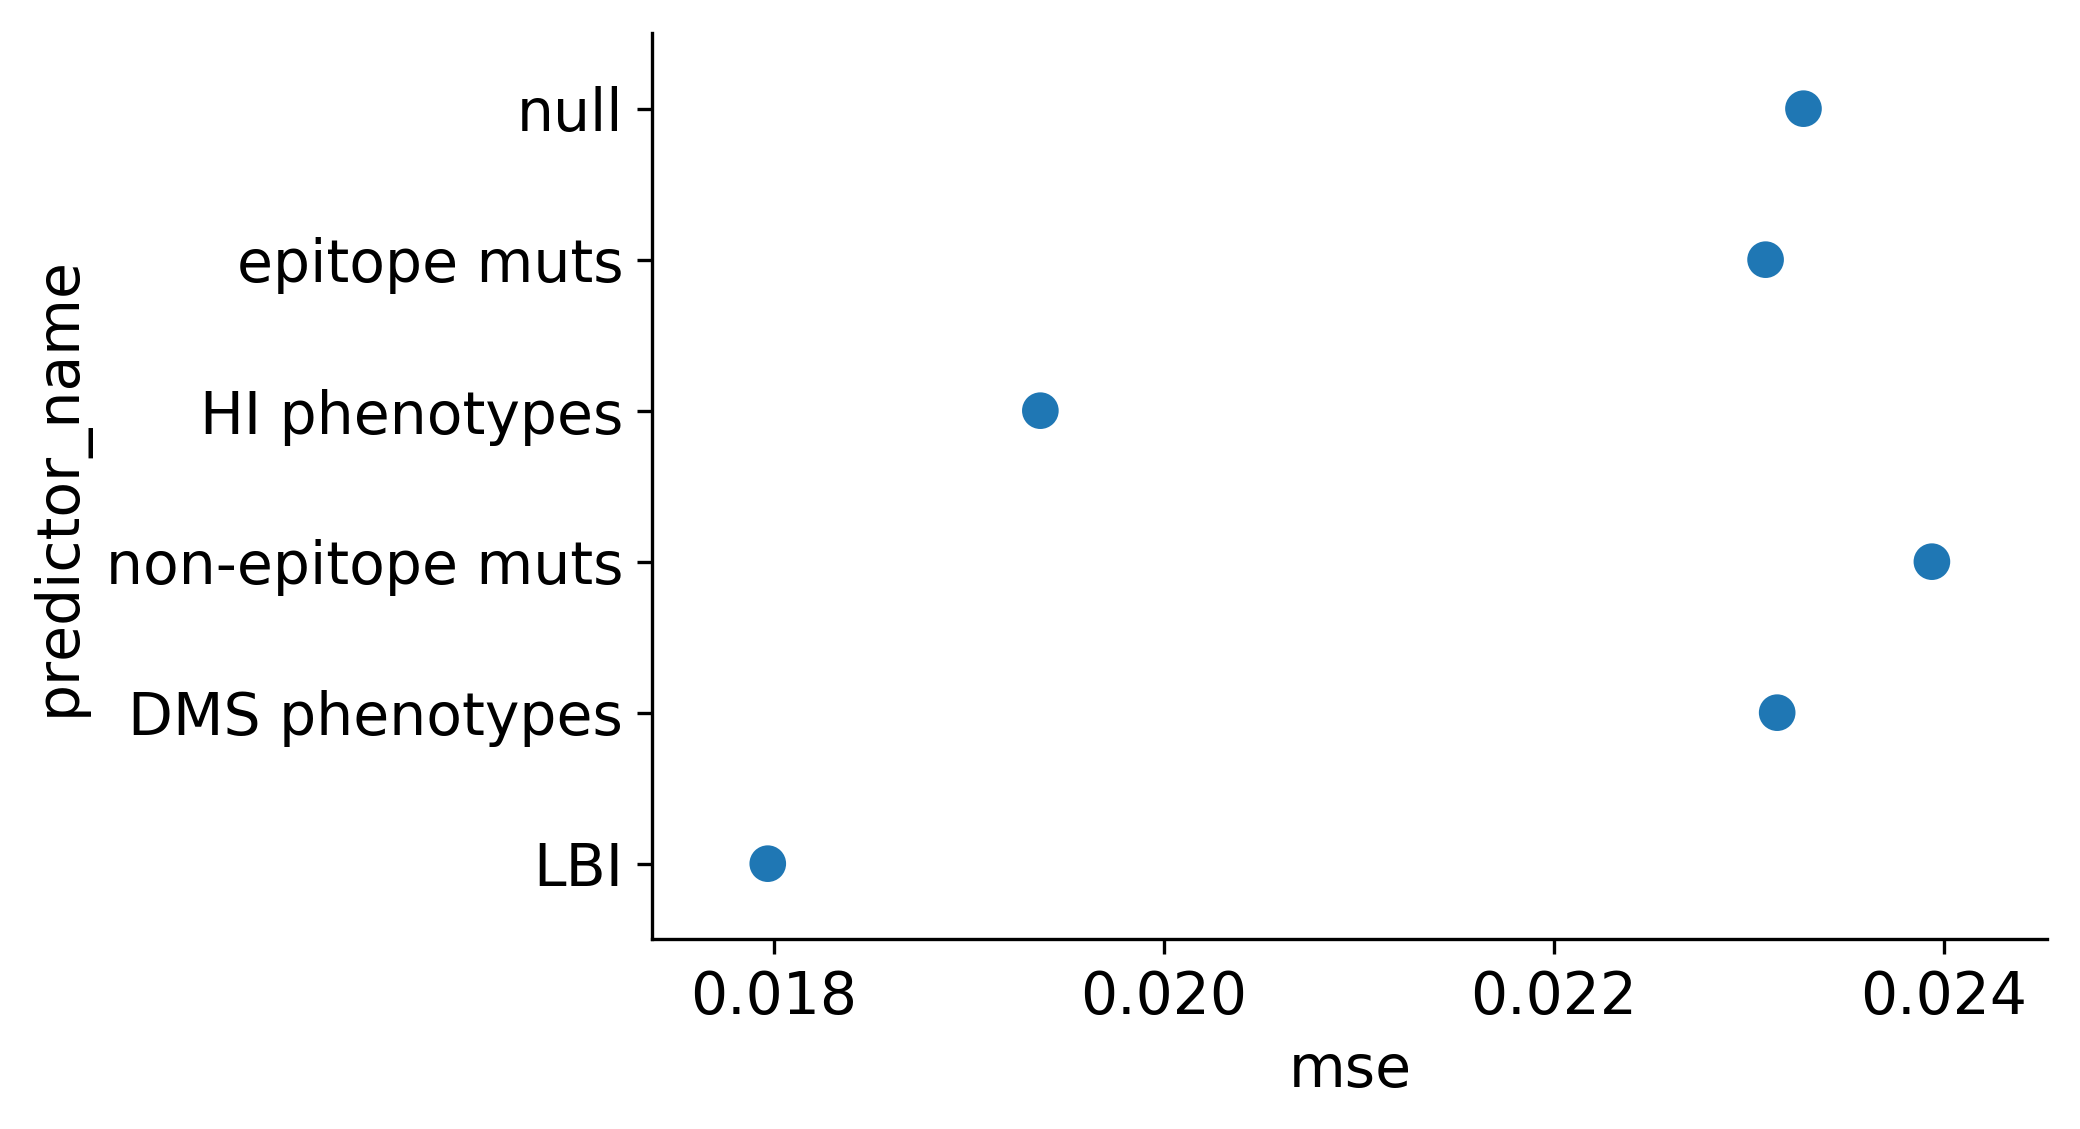

In [157]:
sns.pointplot(
    x="mse",
    y="predictor_name",
    data=mse_df,
    join=False,
    order=predictor_names_order
)

In [158]:
# Calculate mean absolute error
mae = (error_df["sae"] / error_df["n_samples"]).sort_values()
mae

predictor_name
LBI                 0.058329
HI phenotypes       0.060555
null                0.067683
DMS phenotypes      0.068011
epitope muts        0.068869
non-epitope muts    0.069533
dtype: float64

In [159]:
mae_df = mae.reset_index().rename({0: "mae"}, axis=1)
mae_df

predictor_name       mae
0               LBI  0.058329
1     HI phenotypes  0.060555
2              null  0.067683
3    DMS phenotypes  0.068011
4      epitope muts  0.068869
5  non-epitope muts  0.069533

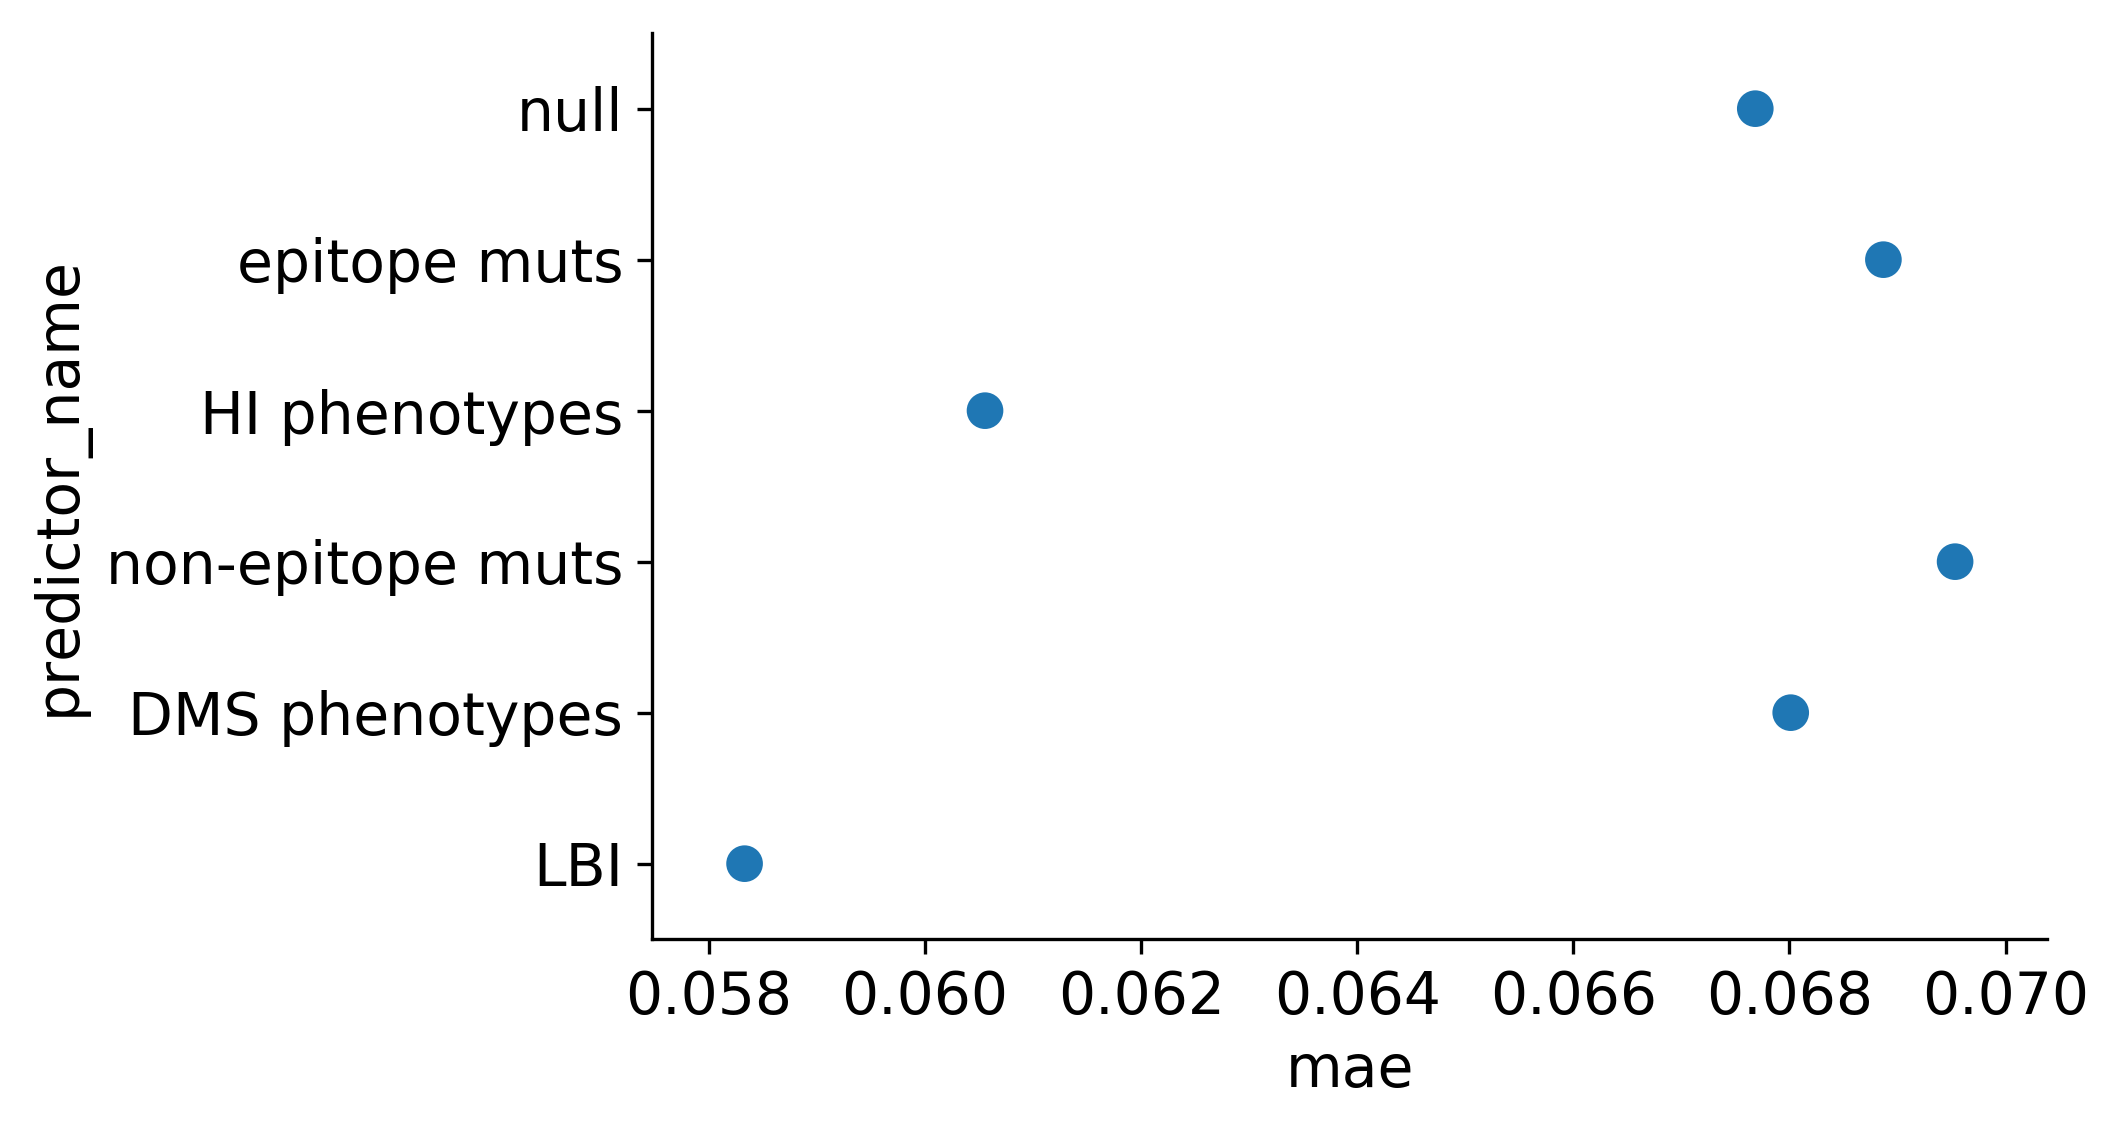

In [161]:
sns.pointplot(
    x="mae",
    y="predictor_name",
    data=mae_df,
    join=False,
    order=predictor_names_order
)

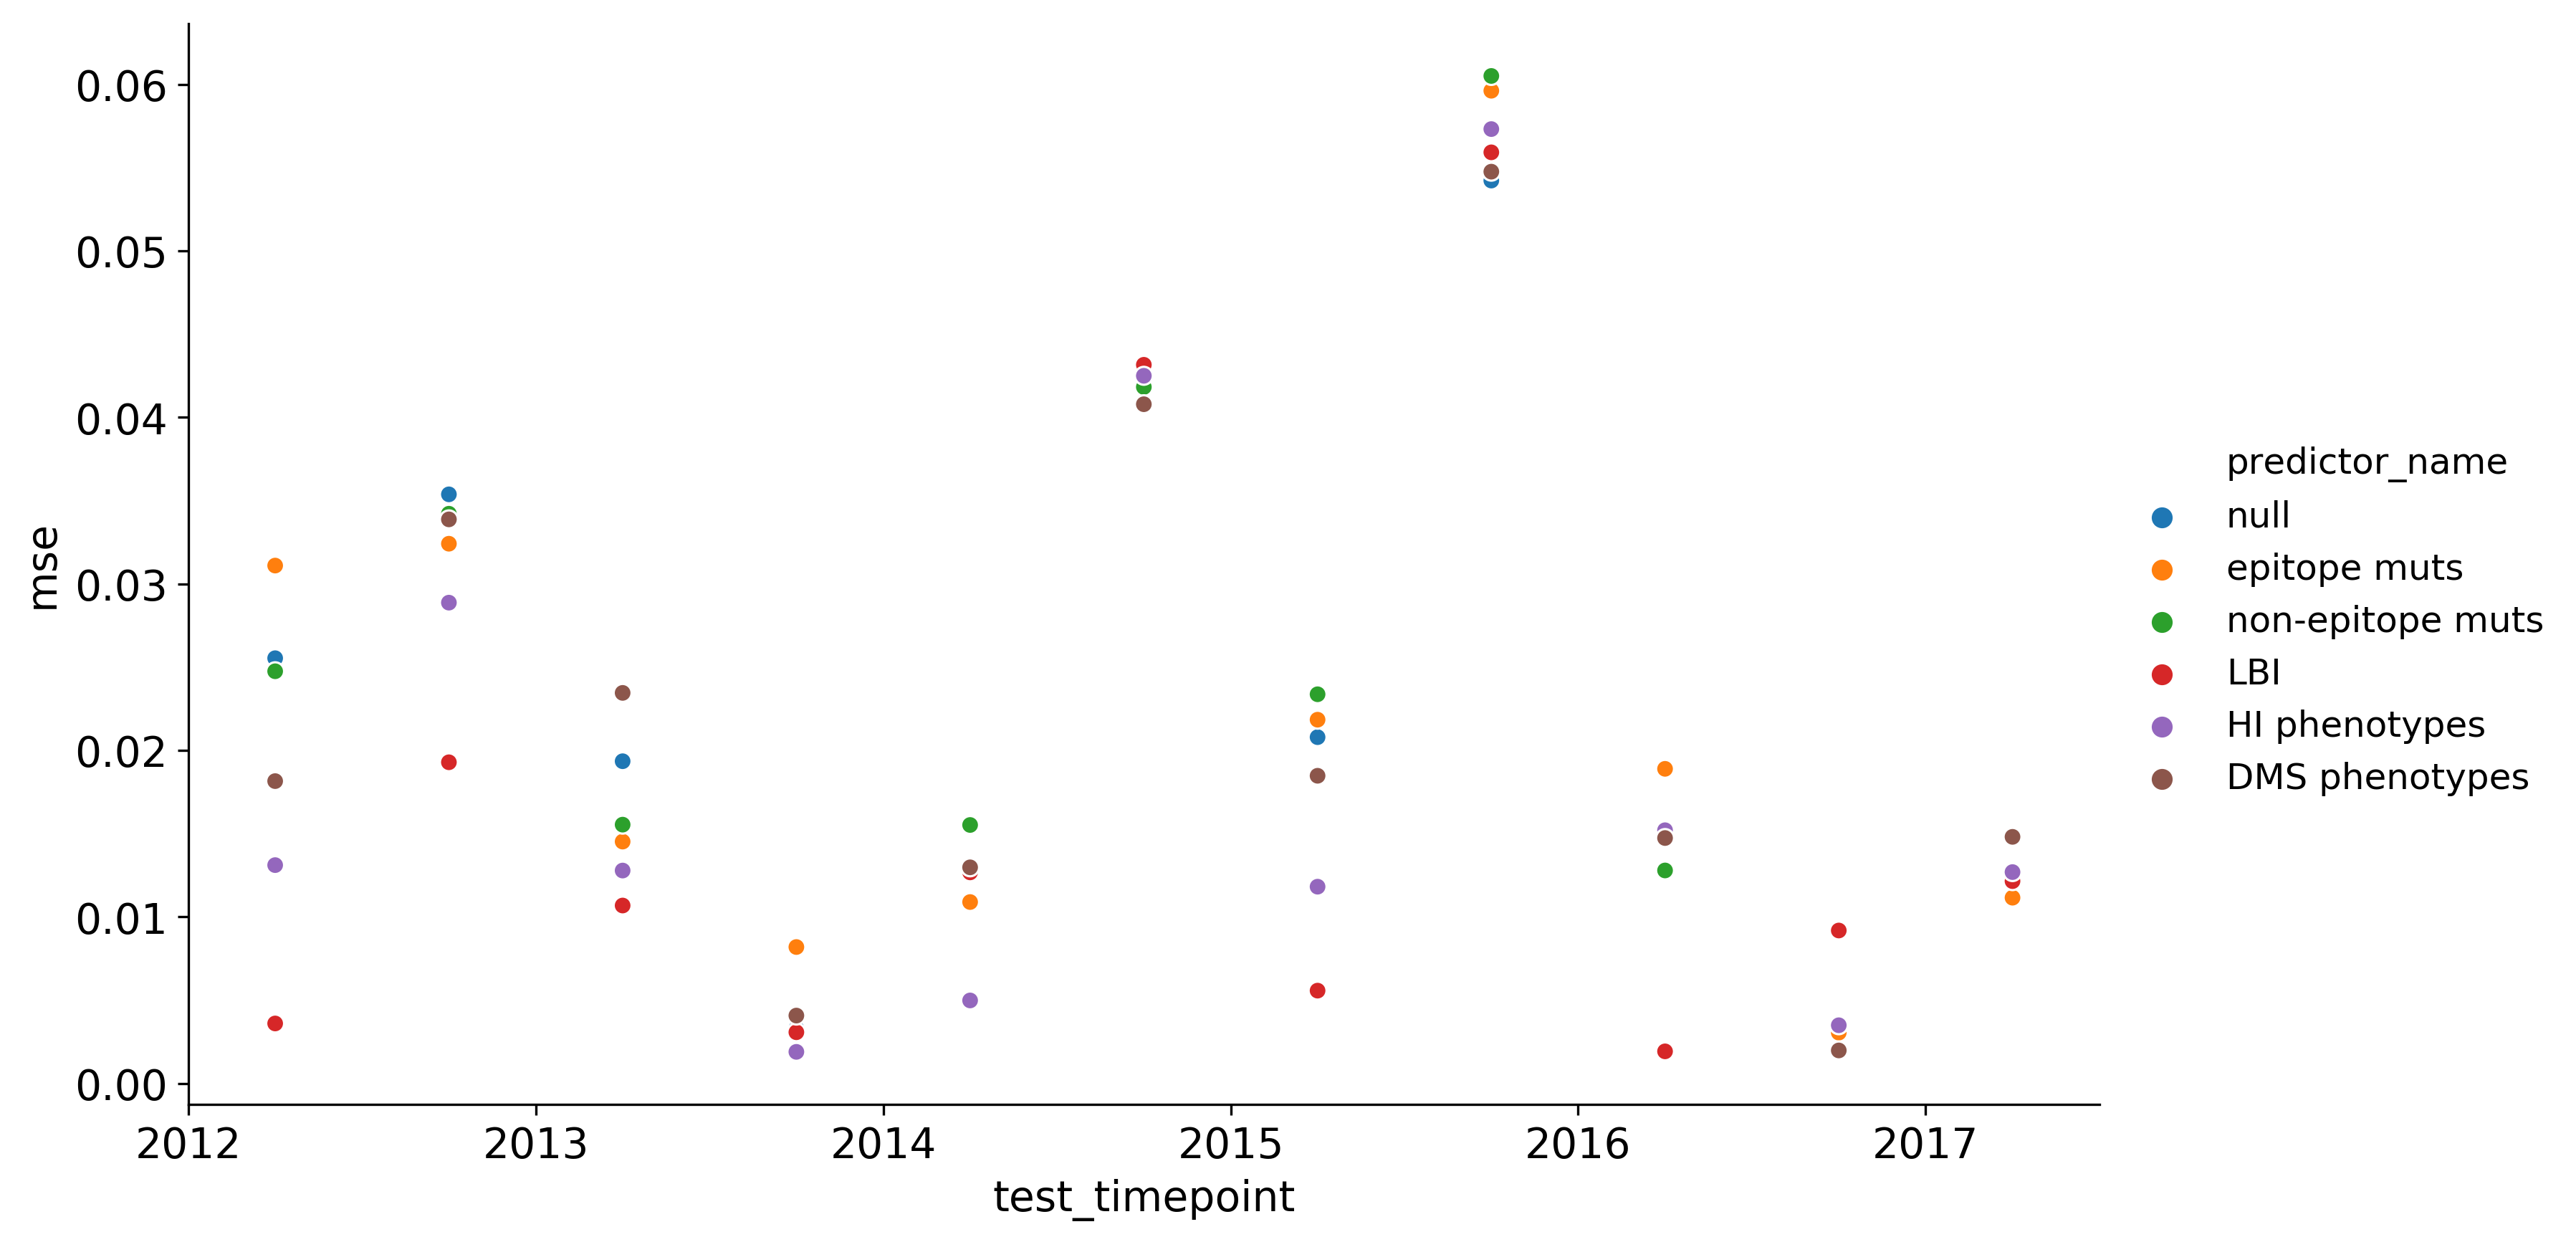

In [162]:
g = sns.relplot(
    "test_timepoint",
    "mse",
    hue="predictor_name",
    data=df,
    height=6,
    aspect=1.7,
    kind="scatter"
)
#for ax in g.axes.flatten():
#    ax.set_xlim(df["test_timepoint"].min() - 1, df["test_timepoint"].max() + 1)

In [163]:
df.columns

Index([u'fn', u'fp', u'last_training_timepoint', u'n_samples',
       u'parameter-cTiterSub', u'parameter-dms', u'parameter-ep',
       u'parameter-ep_x', u'parameter-lbi', u'parameter-ne',
       u'parameter-ne_star', u'parameter-null', u'predictors', u'sae',
       u'sample', u'sse', u'test_timepoint', u'testing_accuracy',
       u'testing_correlation', u'tn', u'tp', u'training_accuracy',
       u'training_correlation', u'training_windows', u'viruses', u'year_range',
       u'predictor_name', u'mse'],
      dtype='object')

In [164]:
df["test_timepoint"].drop_duplicates()

0     2012.25
1     2012.75
2     2013.25
3     2013.75
4     2014.25
5     2014.75
6     2015.25
7     2015.75
8     2016.25
9     2016.75
10    2017.25
Name: test_timepoint, dtype: float64

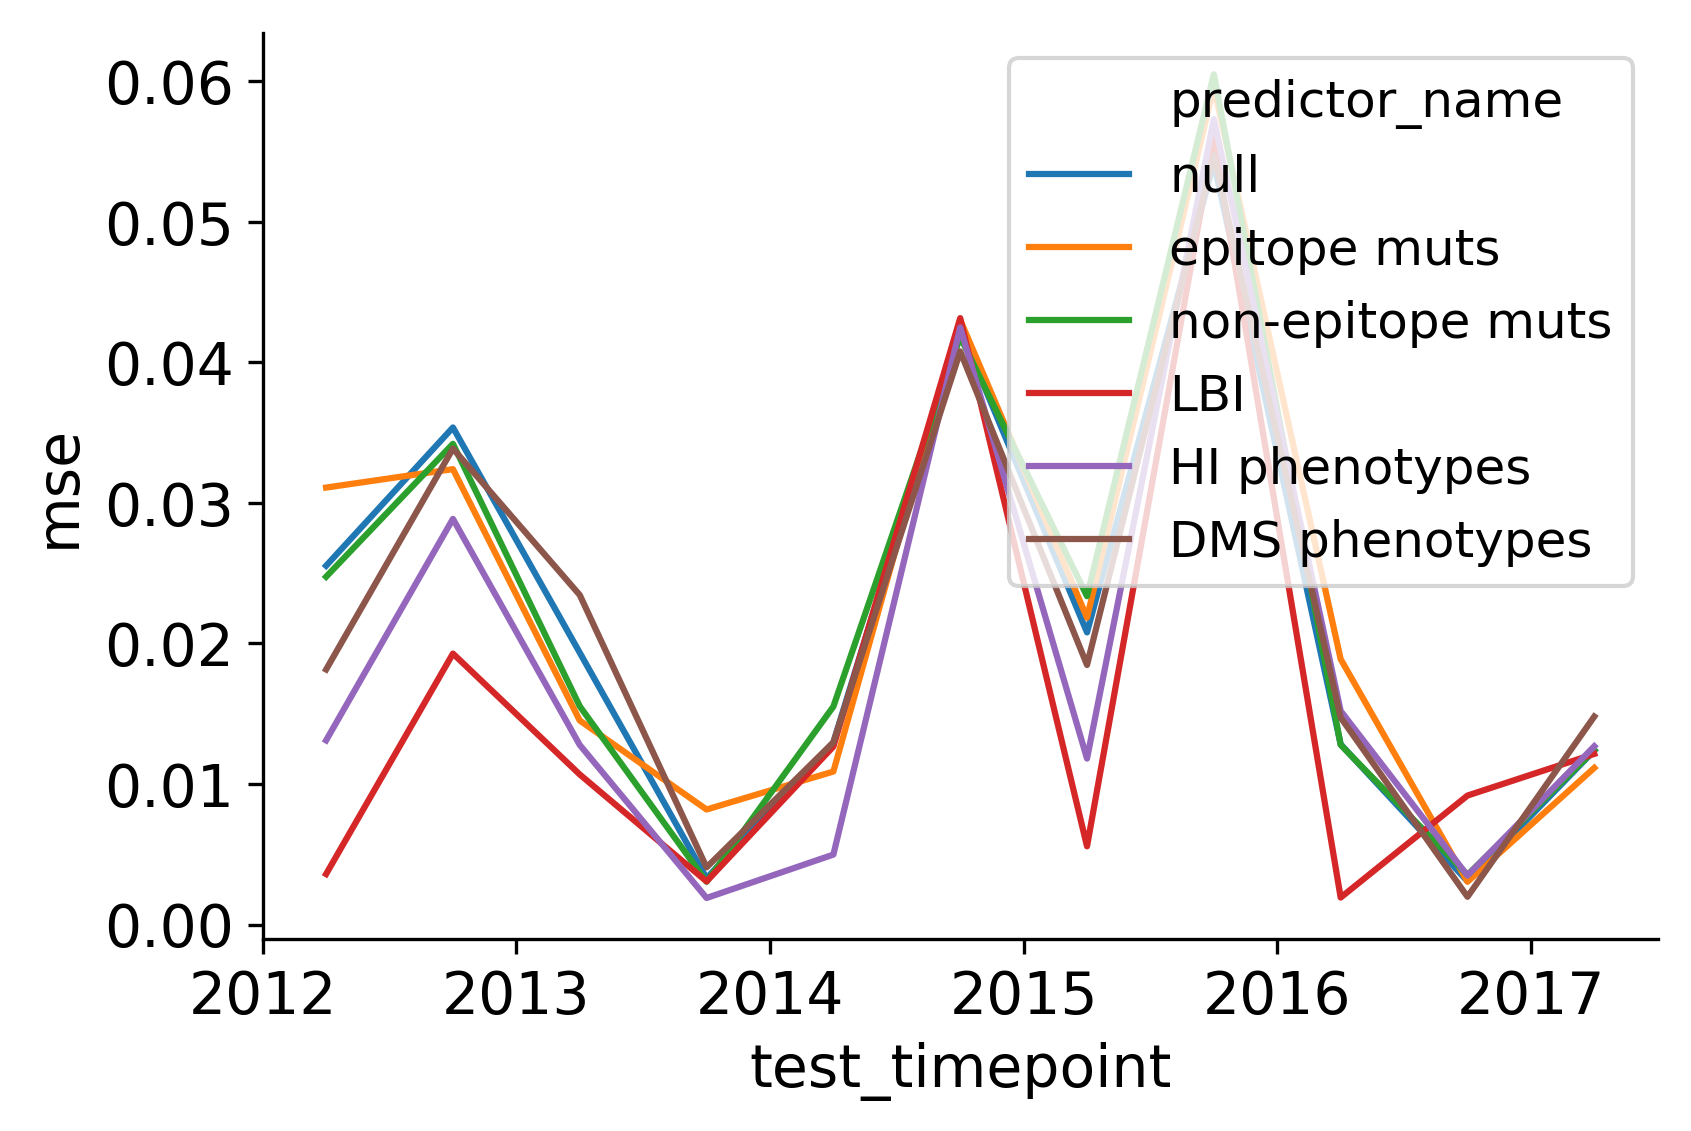

In [166]:
sns.lineplot(
    "test_timepoint",
    "mse",
    data=df,
    ci="sd",
    markers=True,
    dashes=False,
    hue="predictor_name"
)

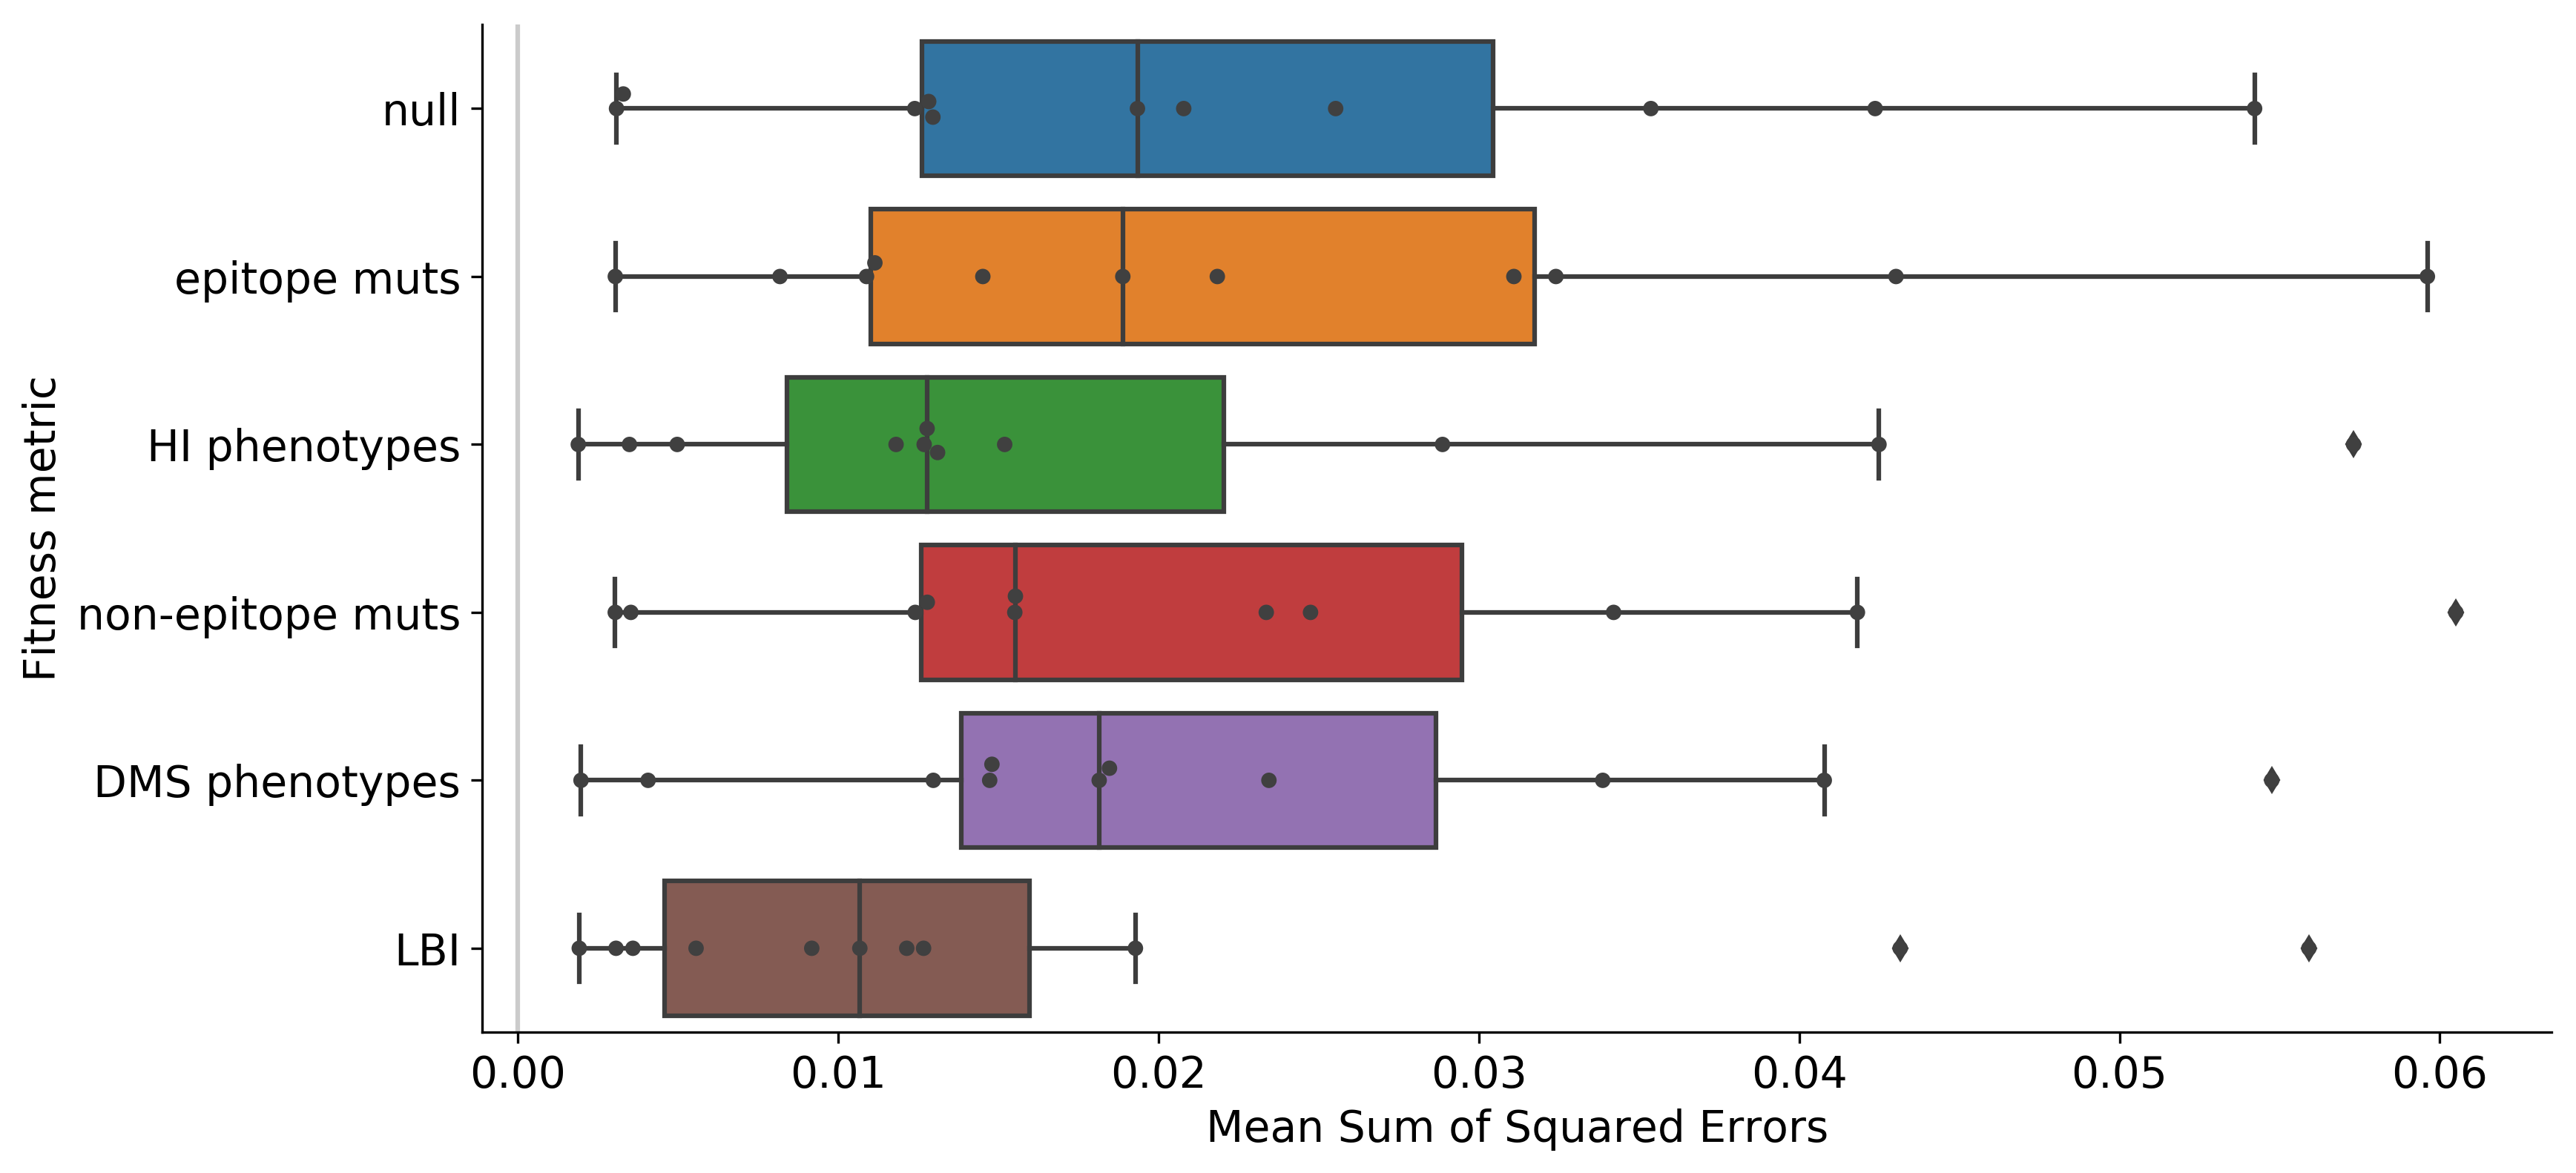

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot training accuracy on the top panel.
sns.boxplot(
    y="predictor_name",
    x="mse",
    data=df,
    ax=ax,
    order=predictor_names_order
)
sns.swarmplot(
    y="predictor_name",
    x="mse",
    data=df,
    ax=ax,
    color="0.25",
    order=predictor_names_order
)

ax.set_xlabel("Mean Sum of Squared Errors")
ax.set_ylabel("Fitness metric")
ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)

sns.despine()

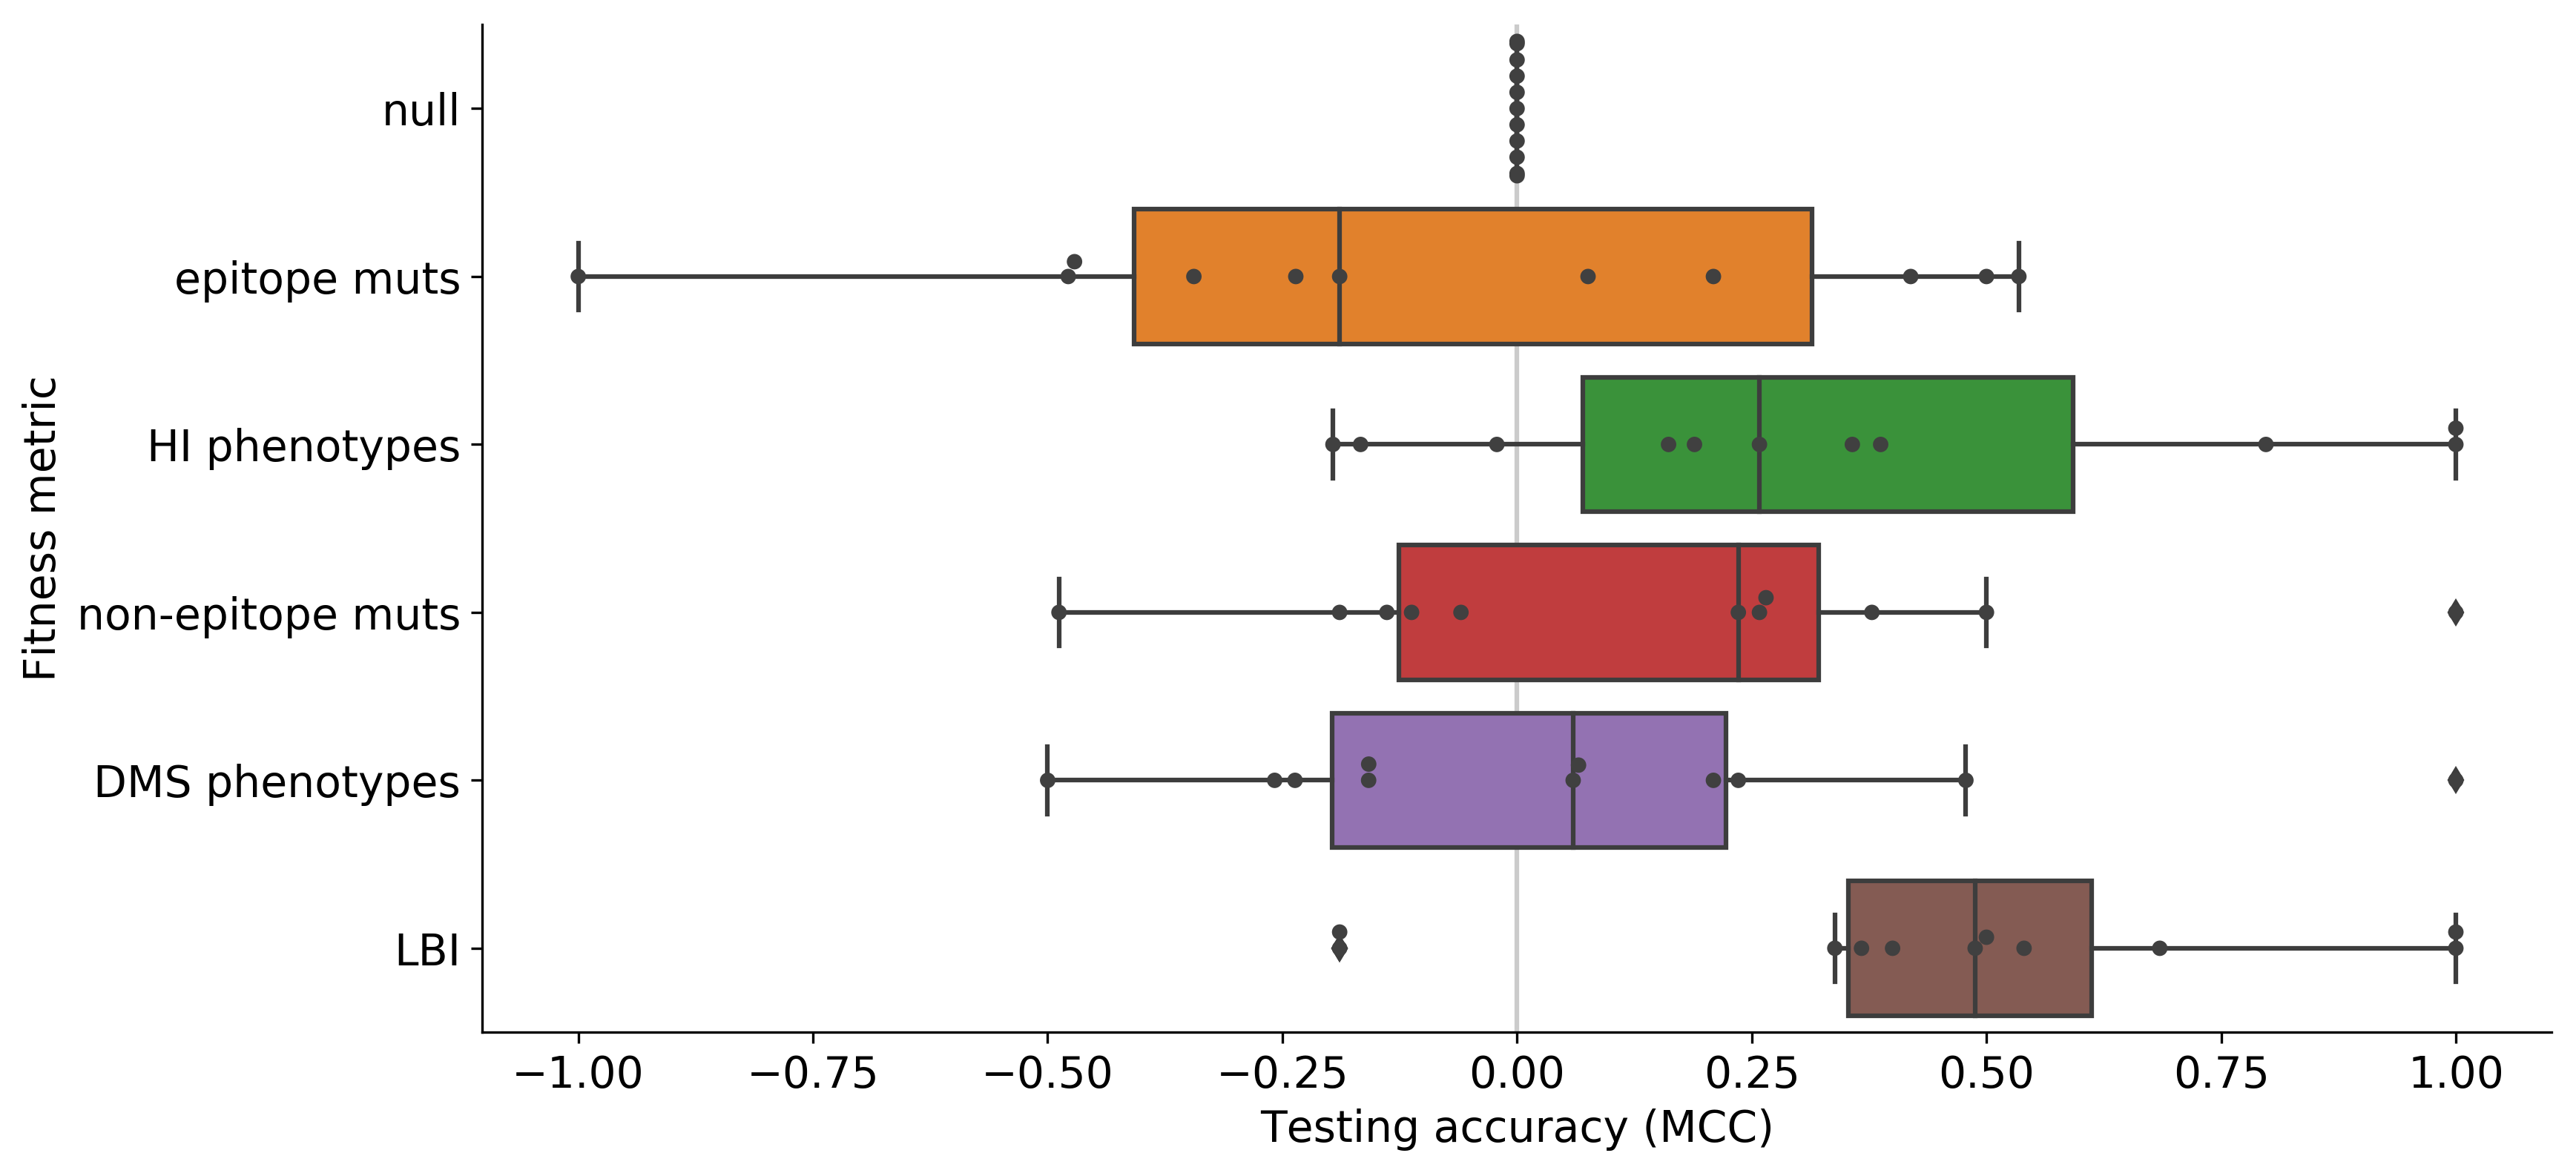

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot training accuracy on the top panel.
sns.boxplot(
    y="predictor_name",
    x="testing_accuracy",
    data=df,
    ax=ax,
    order=predictor_names_order
)
sns.swarmplot(
    y="predictor_name",
    x="testing_accuracy",
    data=df,
    ax=ax,
    color="0.25",
    order=predictor_names_order
)

ax.set_xlabel("Testing accuracy (MCC)")
ax.set_ylabel("Fitness metric")
ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)

sns.despine()

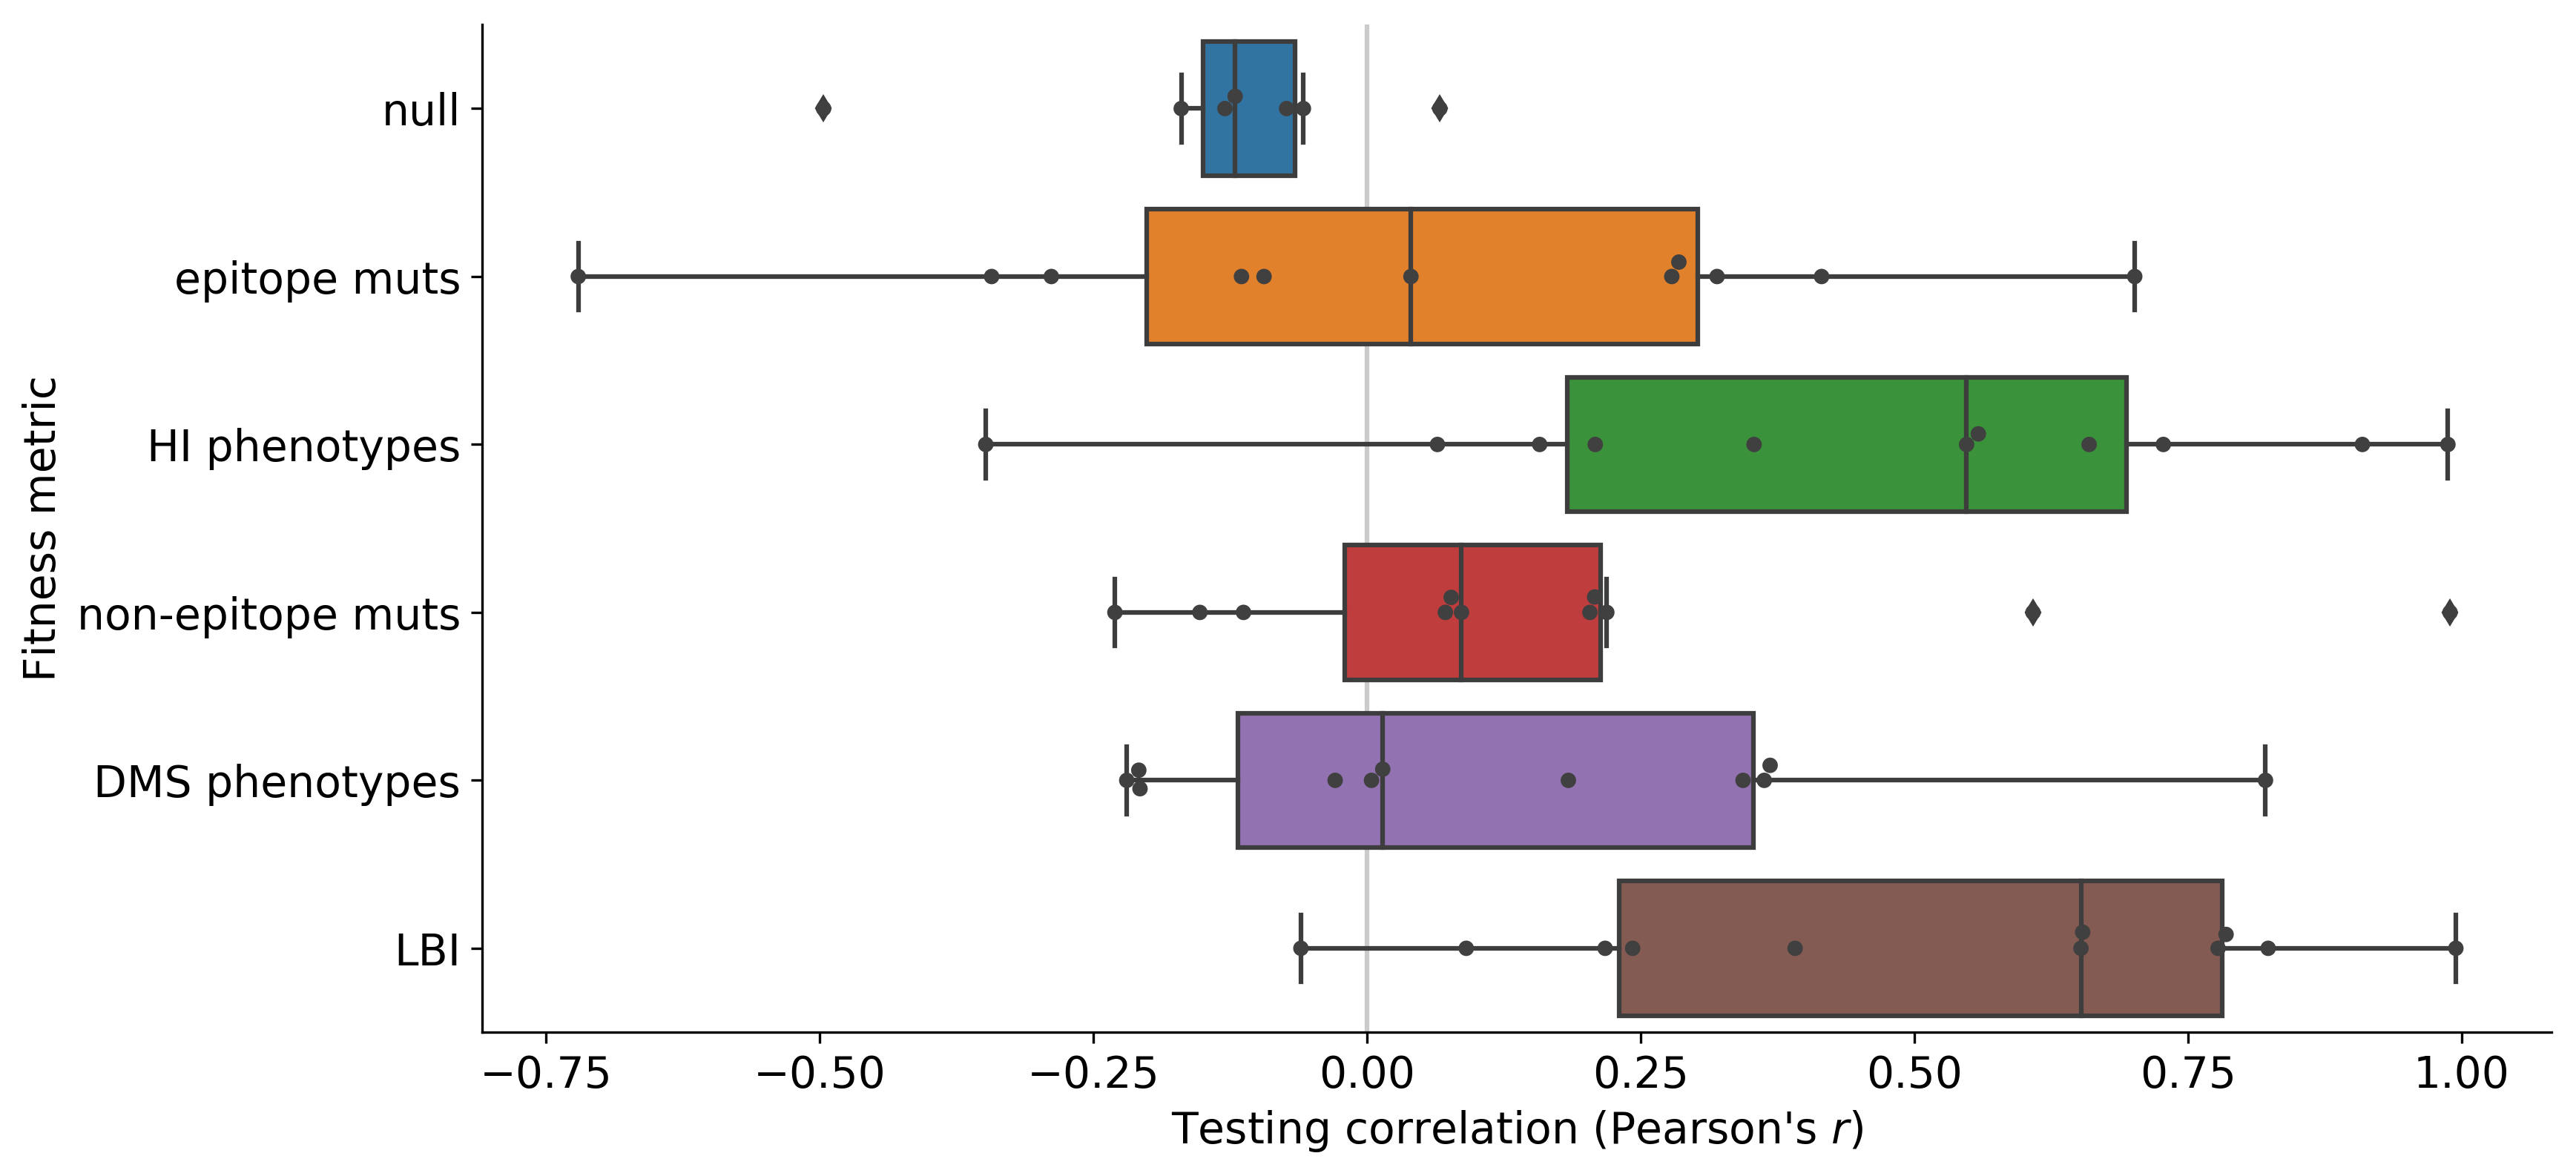

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot training accuracy on the top panel.
sns.boxplot(
    y="predictor_name",
    x="testing_correlation",
    data=df,
    ax=ax,
    order=predictor_names_order
)
sns.swarmplot(
    y="predictor_name",
    x="testing_correlation",
    data=df,
    ax=ax,
    color="0.25",
    order=predictor_names_order
)

ax.set_xlabel("Testing correlation (Pearson's $r$)")
ax.set_ylabel("Fitness metric")
ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)

sns.despine()

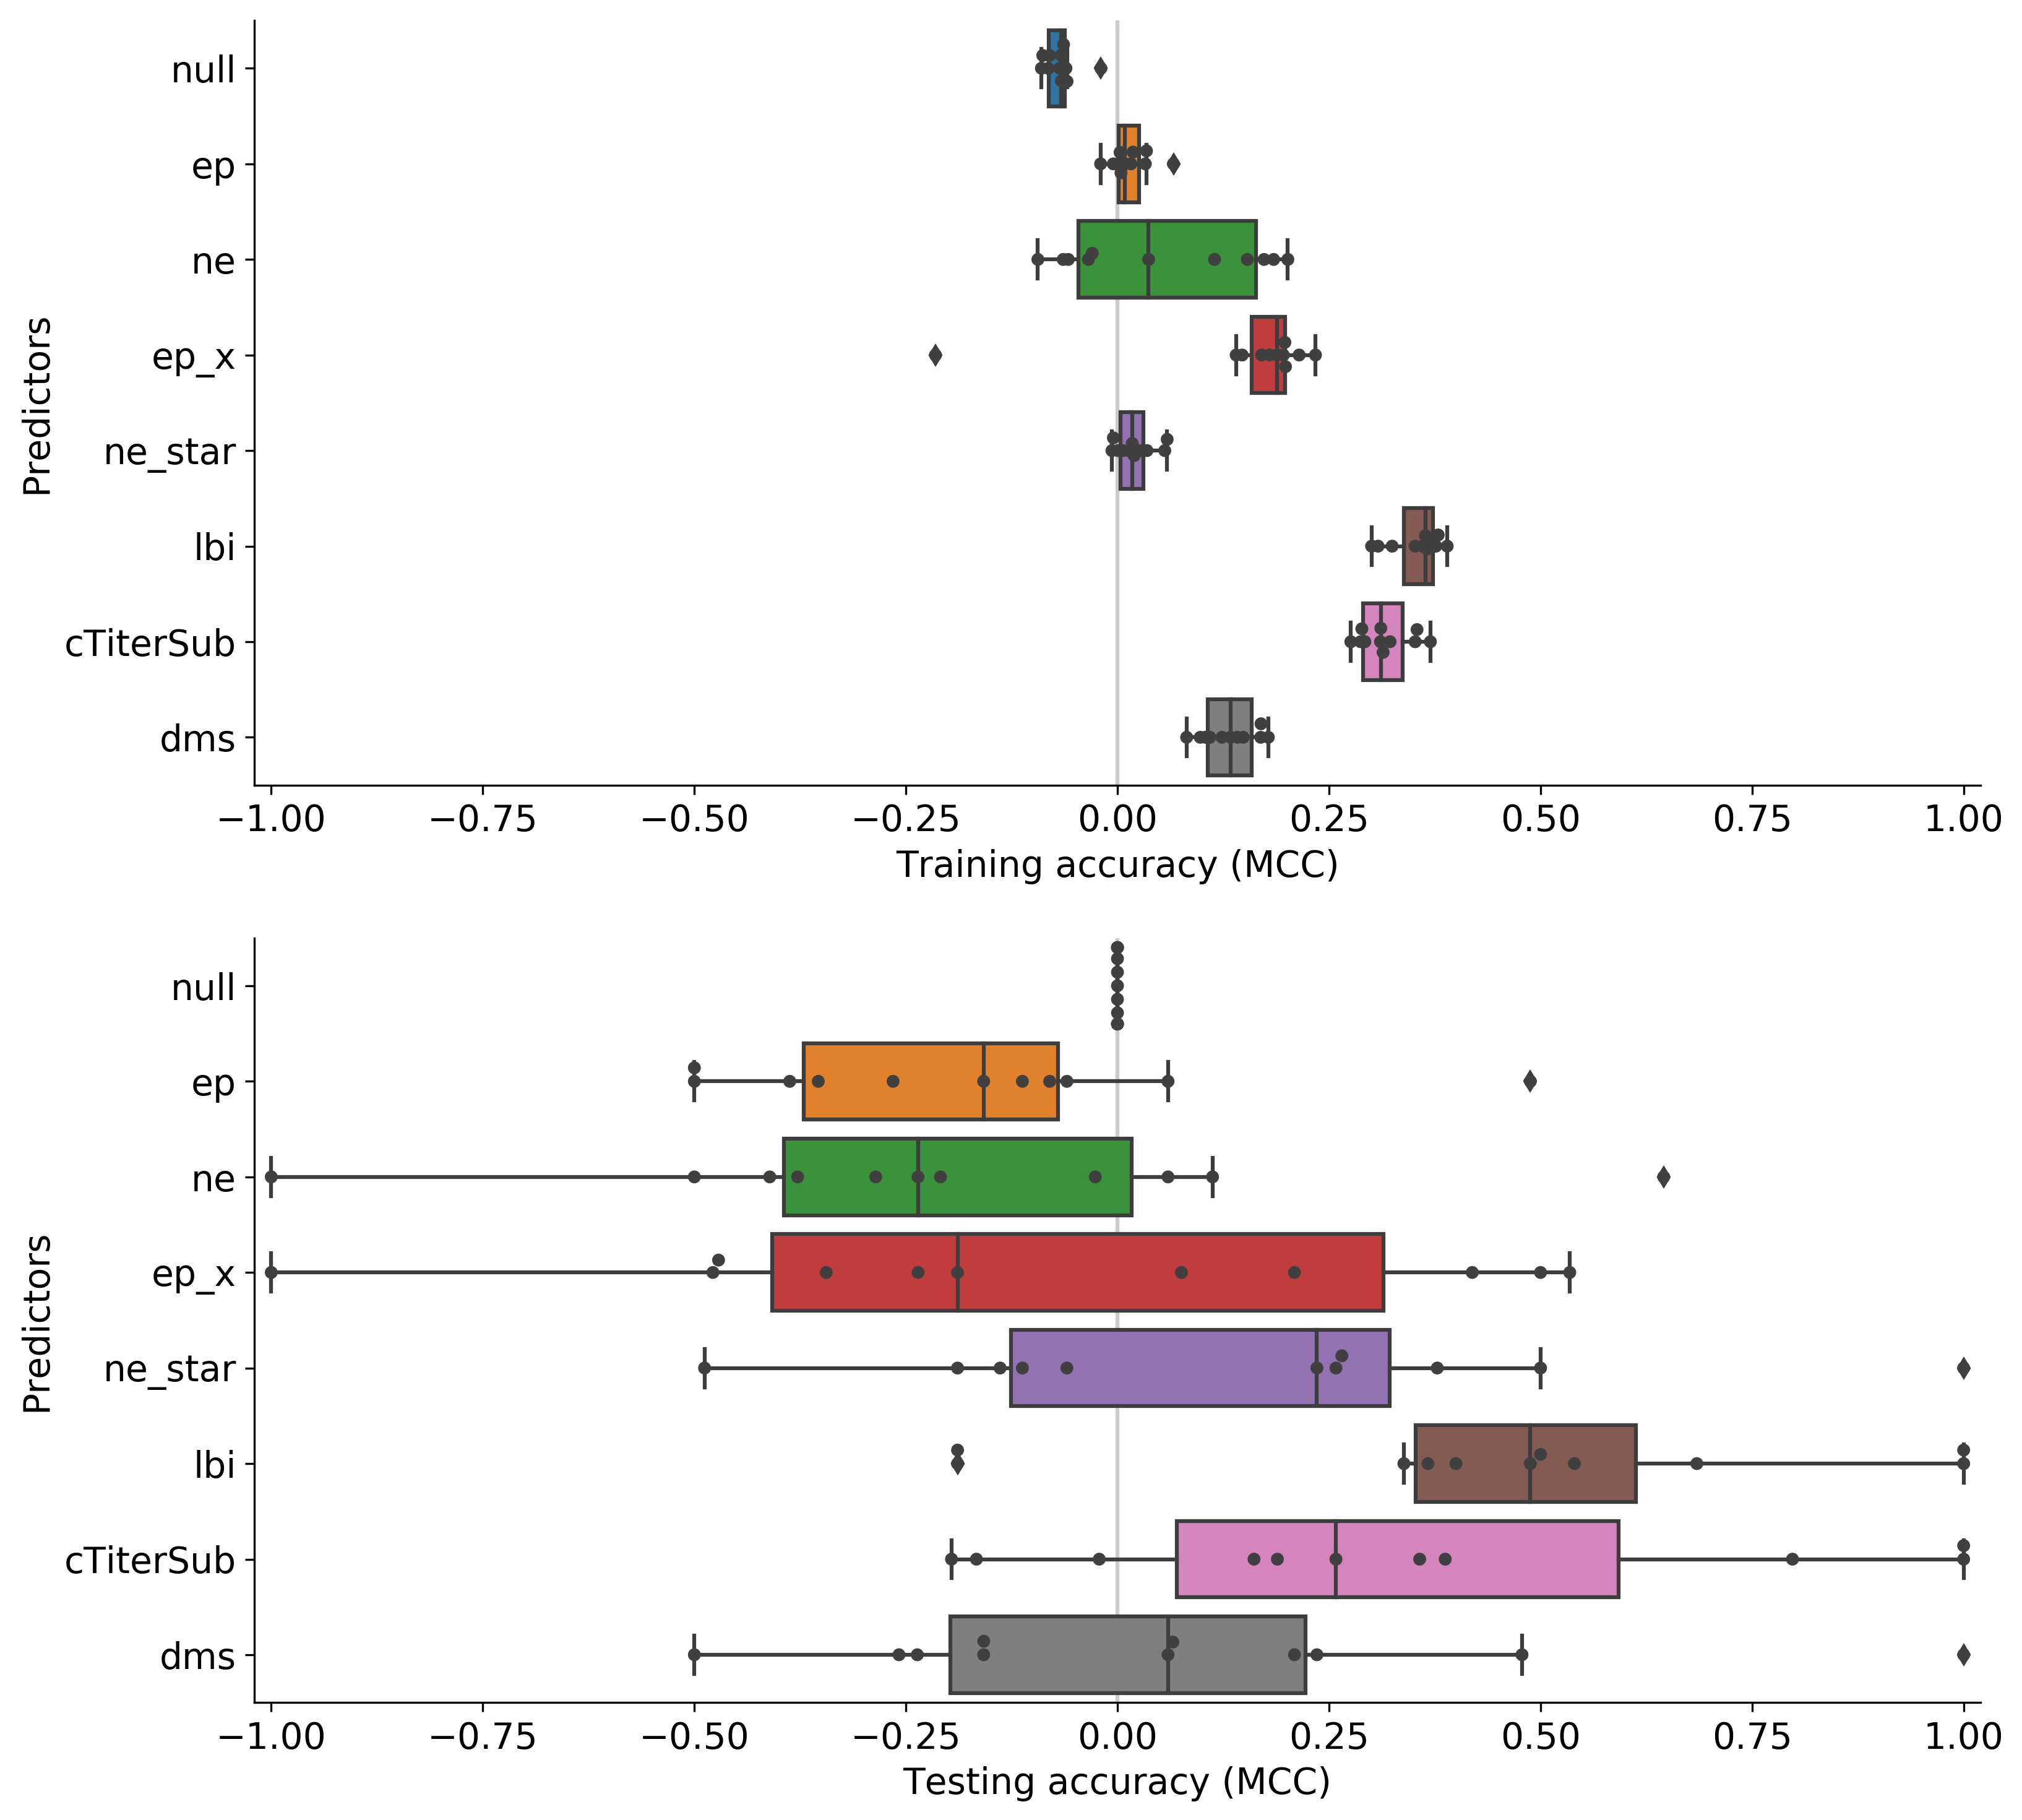

In [72]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot training accuracy on the top panel.
sns.boxplot(
    y="predictor",
    x="training_accuracy",
    data=df,
    ax=axes[0]
)
sns.swarmplot(
    y="predictors",
    x="training_accuracy",
    data=df,
    ax=axes[0],
    color="0.25"
)

axes[0].set_xlabel("Training accuracy (MCC)")
axes[0].set_ylabel("Predictors")
axes[0].axvline(0, color="#999999", alpha=0.5, zorder=-10)
axes[0].set_xlim(-1.02, 1.02)

# Plot testing accuracy on the bottom panel.
sns.boxplot(
    y="predictors",
    x="testing_accuracy",
    data=df,
    ax=axes[1]
)
sns.swarmplot(
    y="predictors",
    x="testing_accuracy",
    data=df,
    ax=axes[1],
    color="0.25"
)

axes[1].set_xlabel("Testing accuracy (MCC)")
axes[1].set_ylabel("Predictors")
axes[1].axvline(0, color="#999999", alpha=0.5, zorder=-10)
axes[1].set_xlim(-1.02, 1.02)

sns.despine()

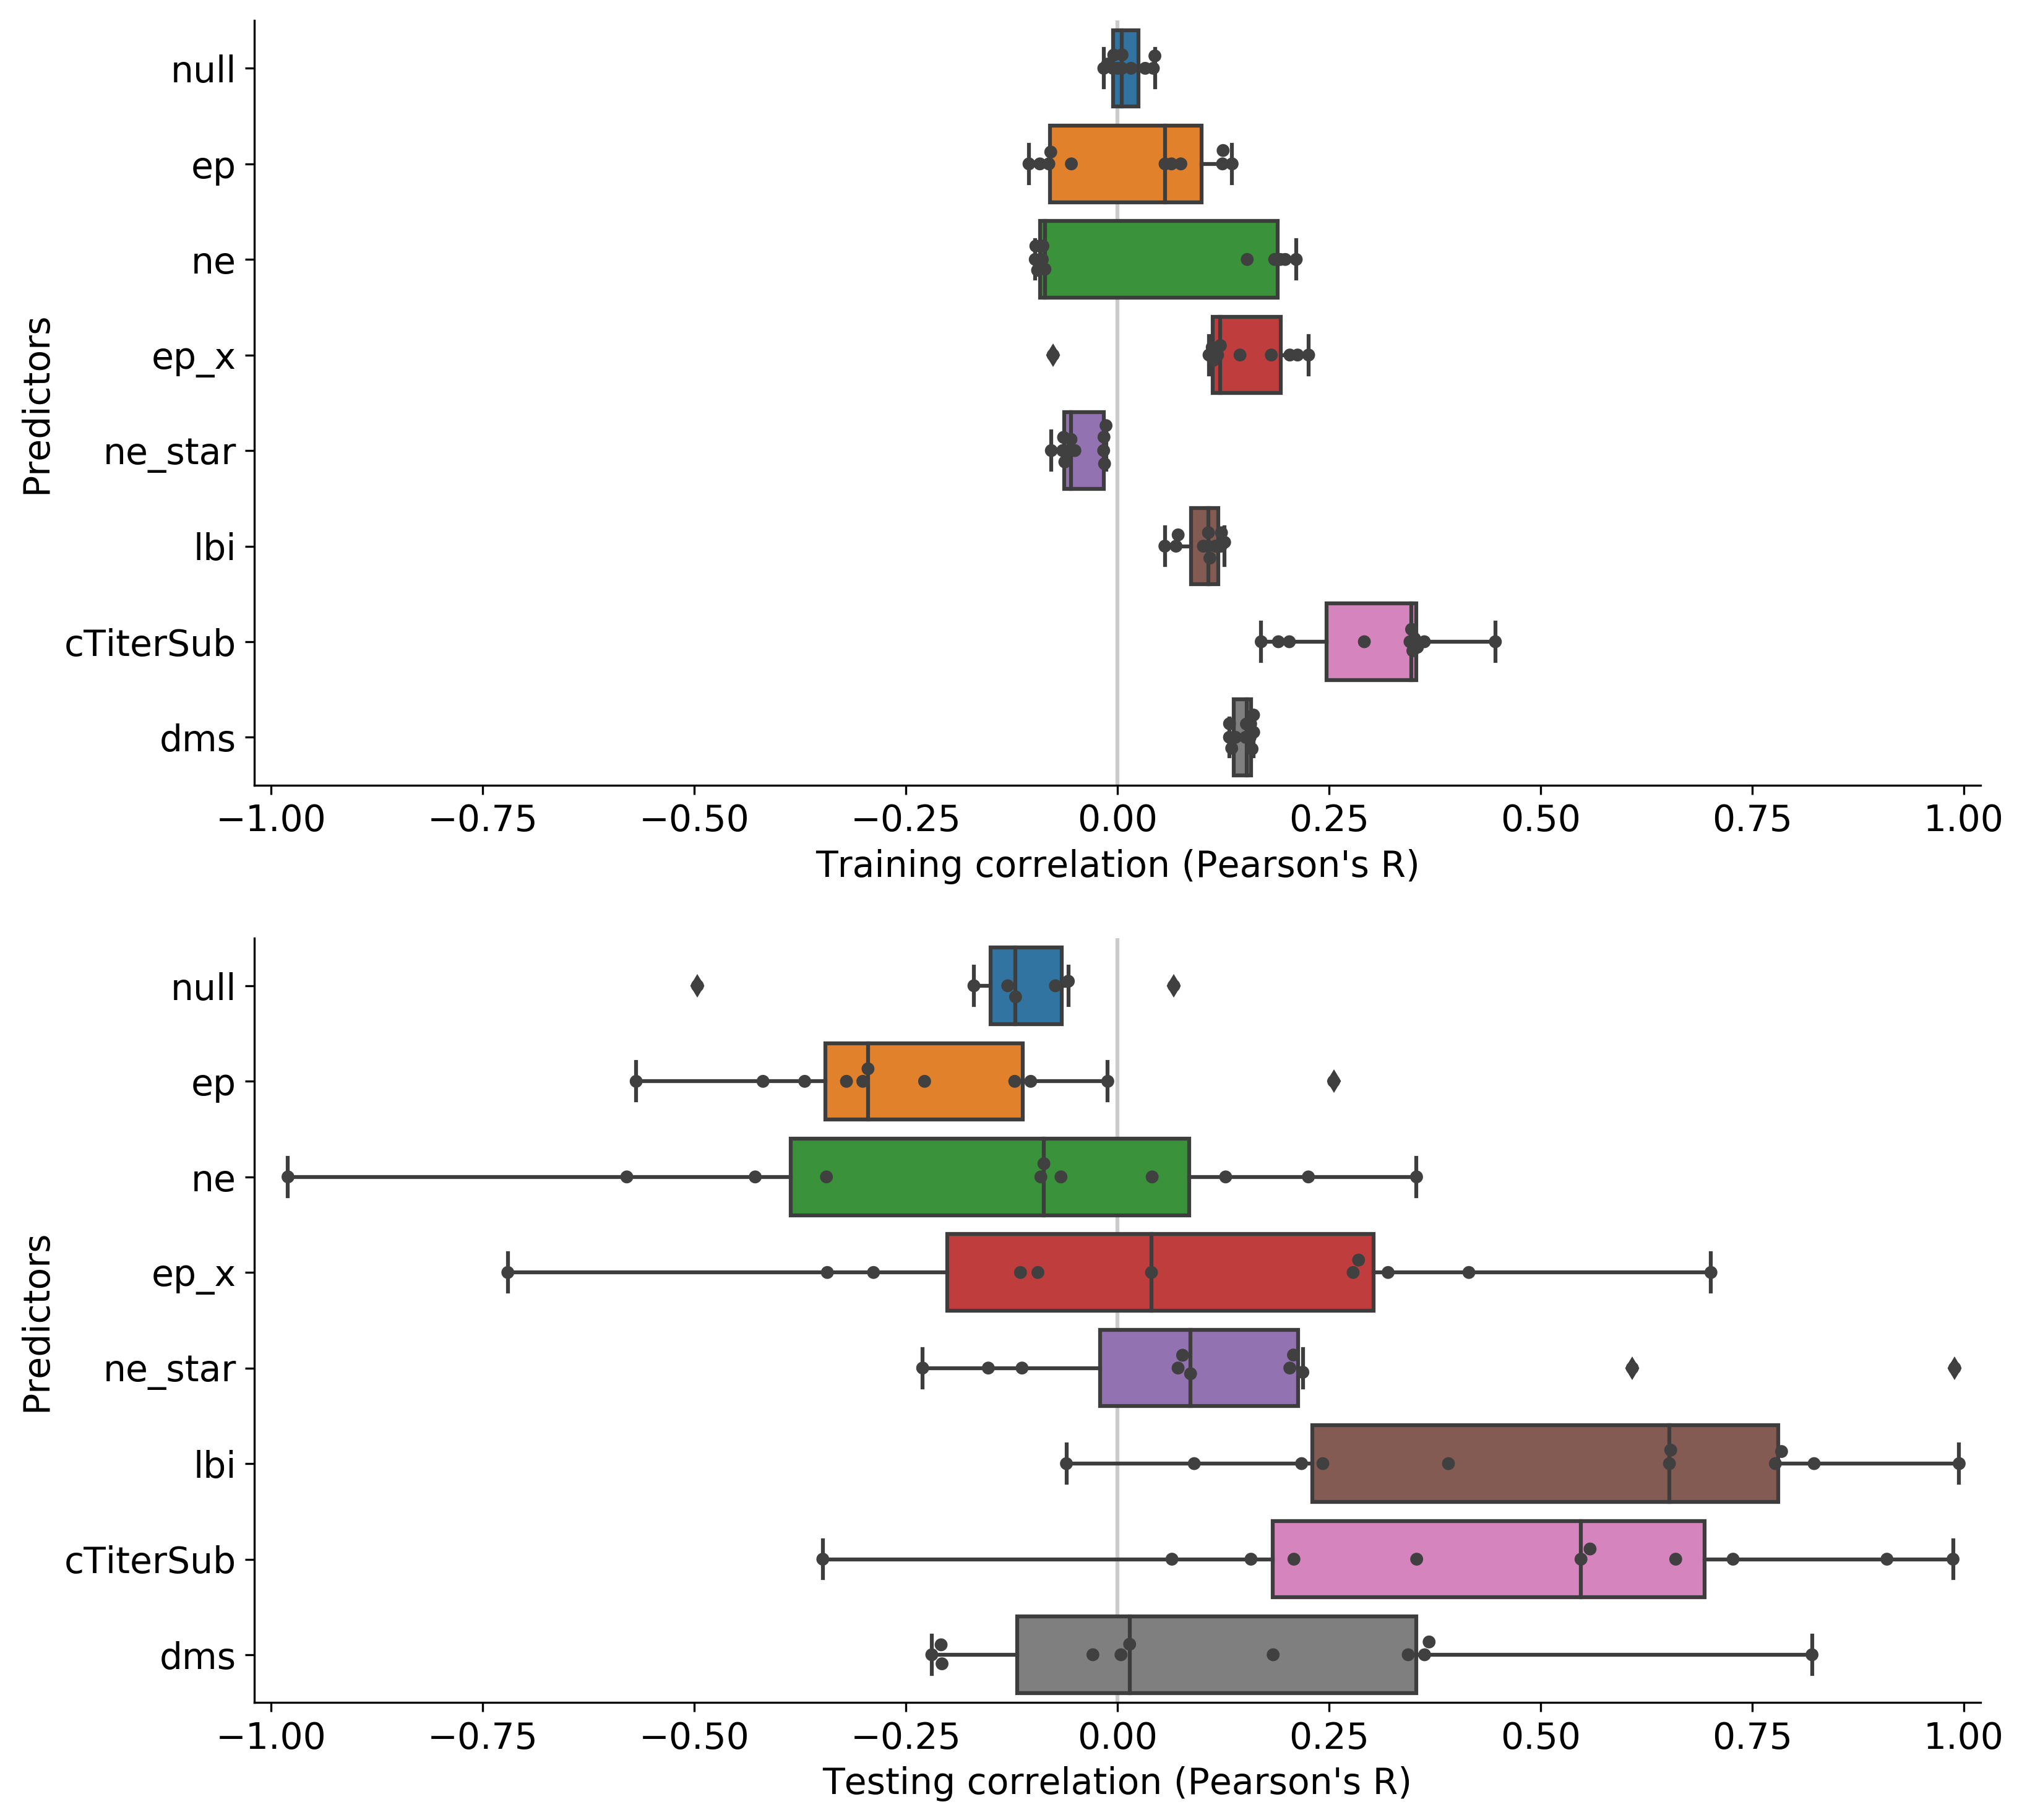

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot training correlation on the top panel.
sns.boxplot(
    y="predictors",
    x="training_correlation",
    data=df,
    ax=axes[0]
)
sns.swarmplot(
    y="predictors",
    x="training_correlation",
    data=df,
    ax=axes[0],
    color="0.25"
)

axes[0].set_xlabel("Training correlation (Pearson's R)")
axes[0].set_ylabel("Predictors")
axes[0].axvline(0, color="#999999", alpha=0.5, zorder=-10)
axes[0].set_xlim(-1.02, 1.02)

# Plot testing correlation on the bottom panel.
sns.boxplot(
    y="predictors",
    x="testing_correlation",
    data=df,
    ax=axes[1]
)
sns.swarmplot(
    y="predictors",
    x="testing_correlation",
    data=df,
    ax=axes[1],
    color="0.25"
)

axes[1].set_xlabel("Testing correlation (Pearson's R)")
axes[1].set_ylabel("Predictors")
axes[1].axvline(0, color="#999999", alpha=0.5, zorder=-10)
axes[1].set_xlim(-1.02, 1.02)

sns.despine()

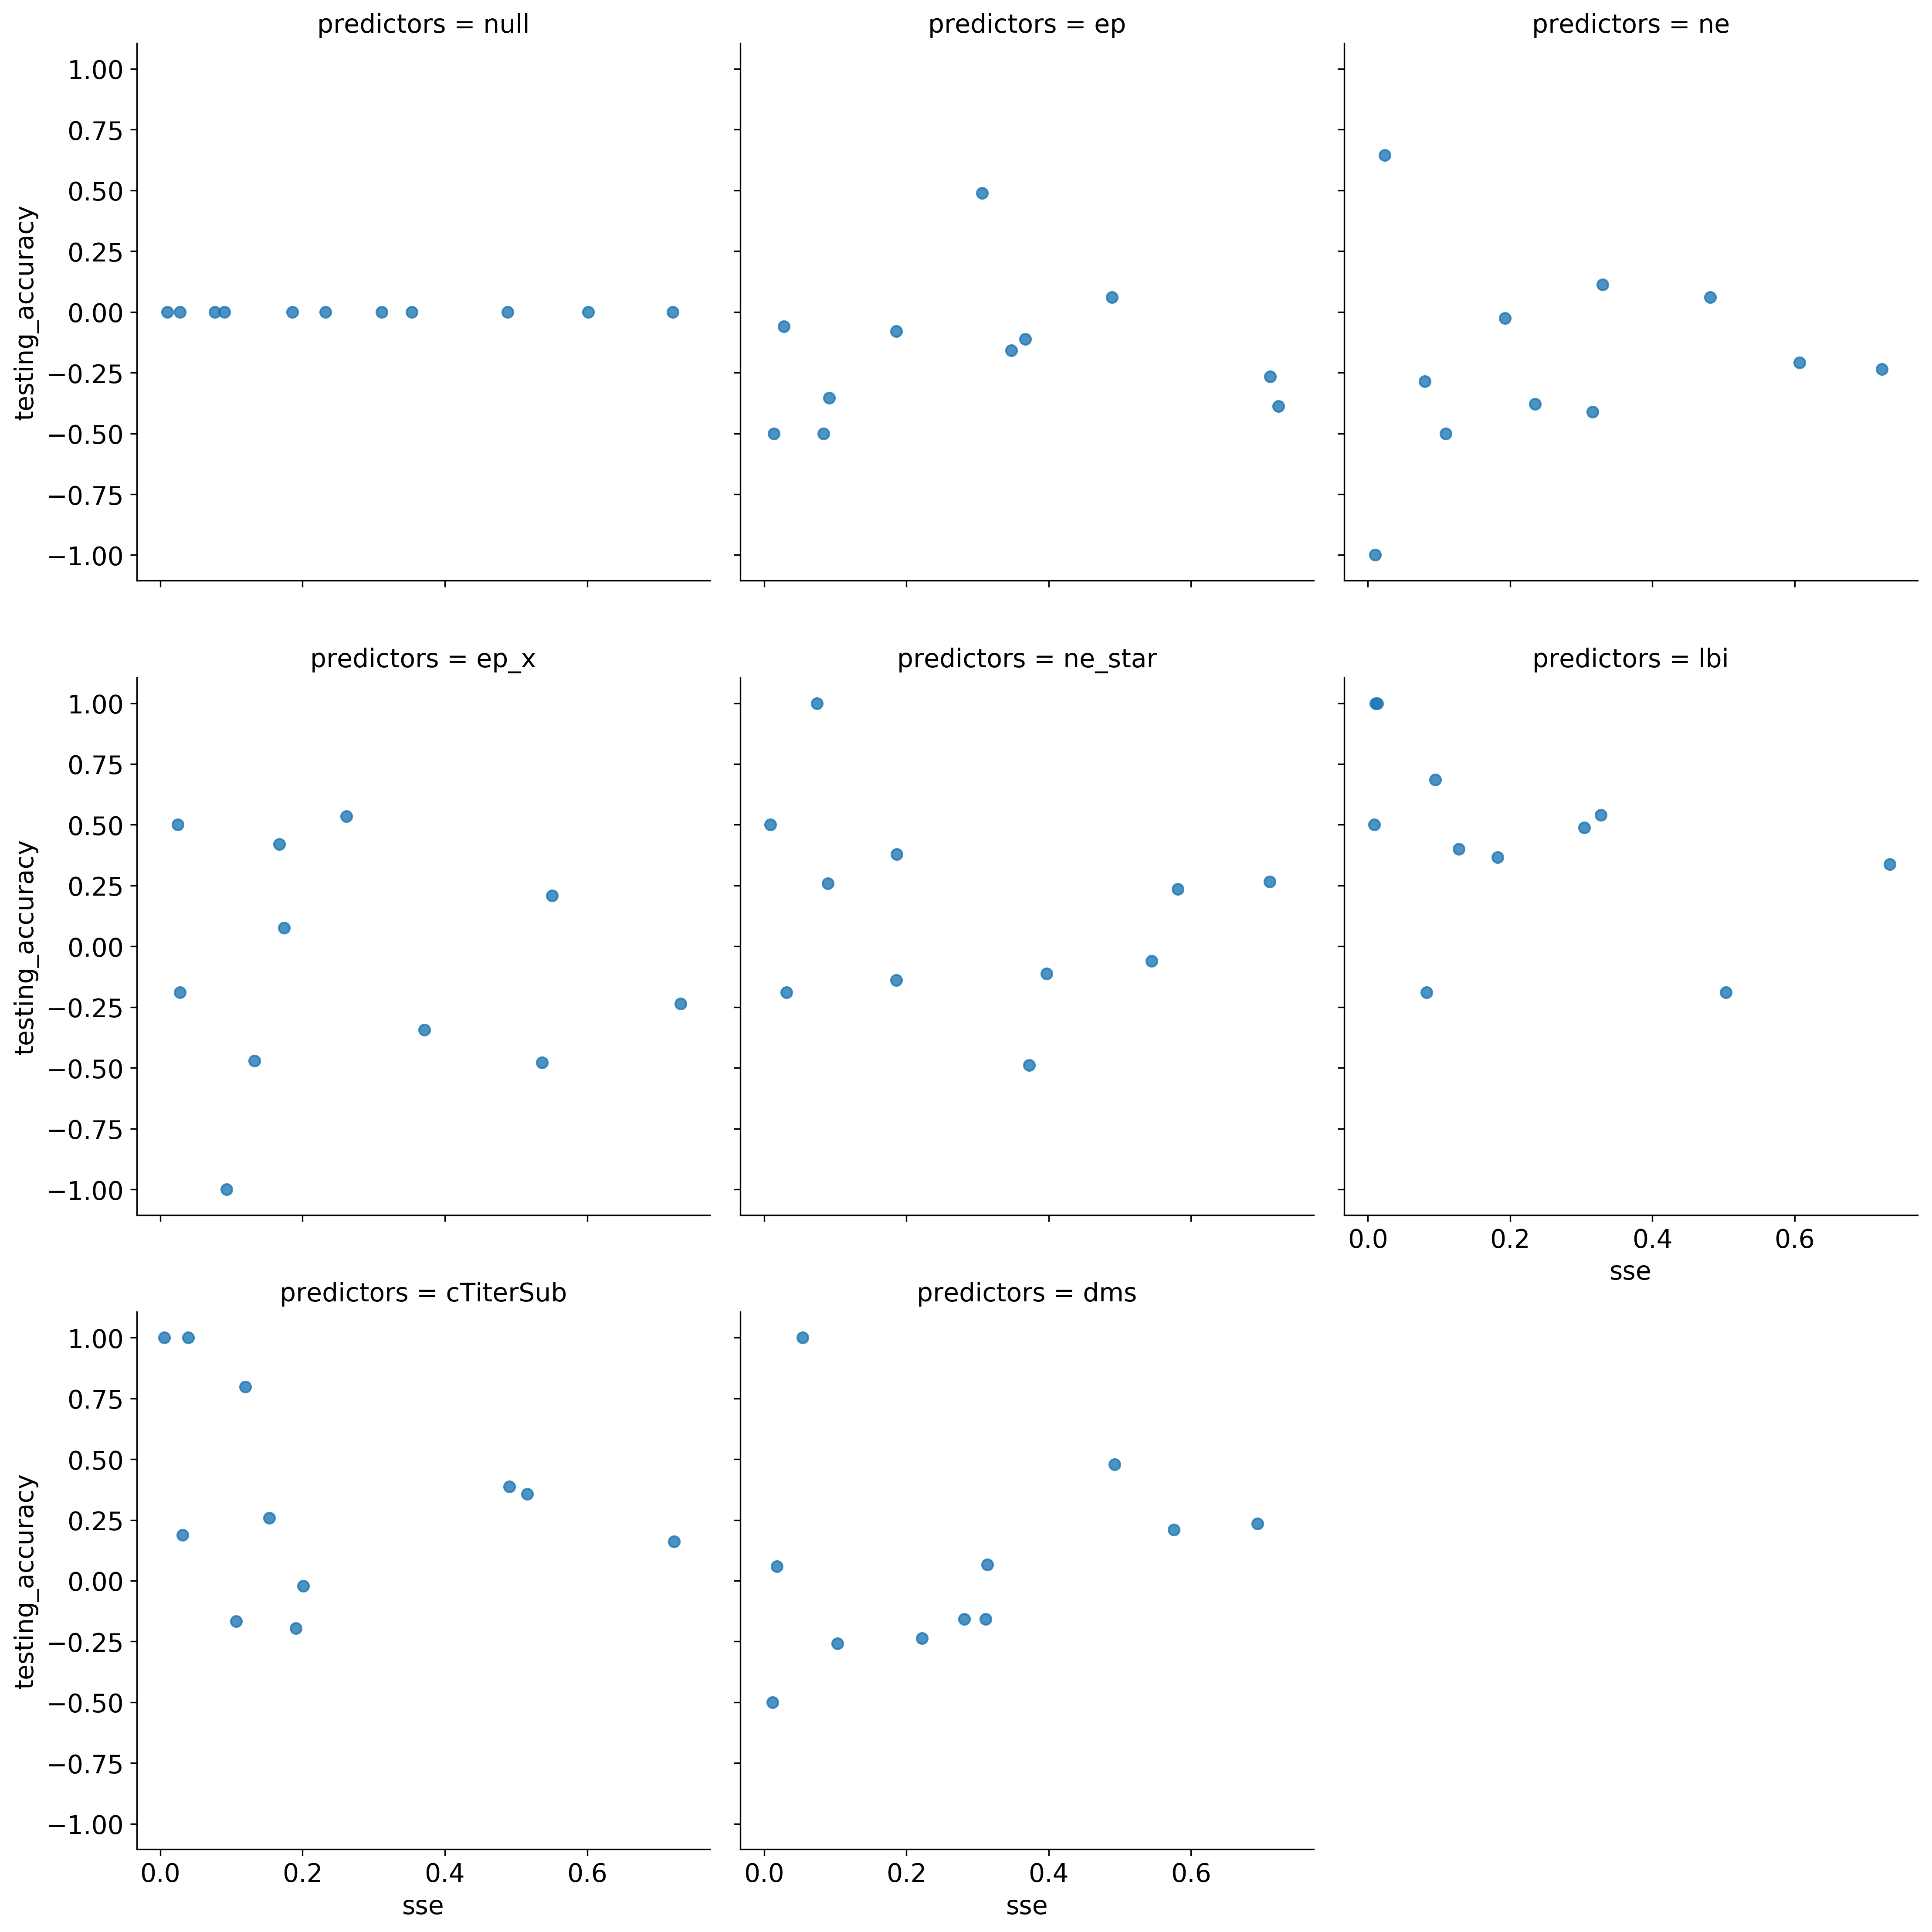

In [21]:
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.lmplot(
    x="sse",
    y="testing_accuracy",
    data=df,
    col="predictors",
    col_wrap=3,
    fit_reg=False
)

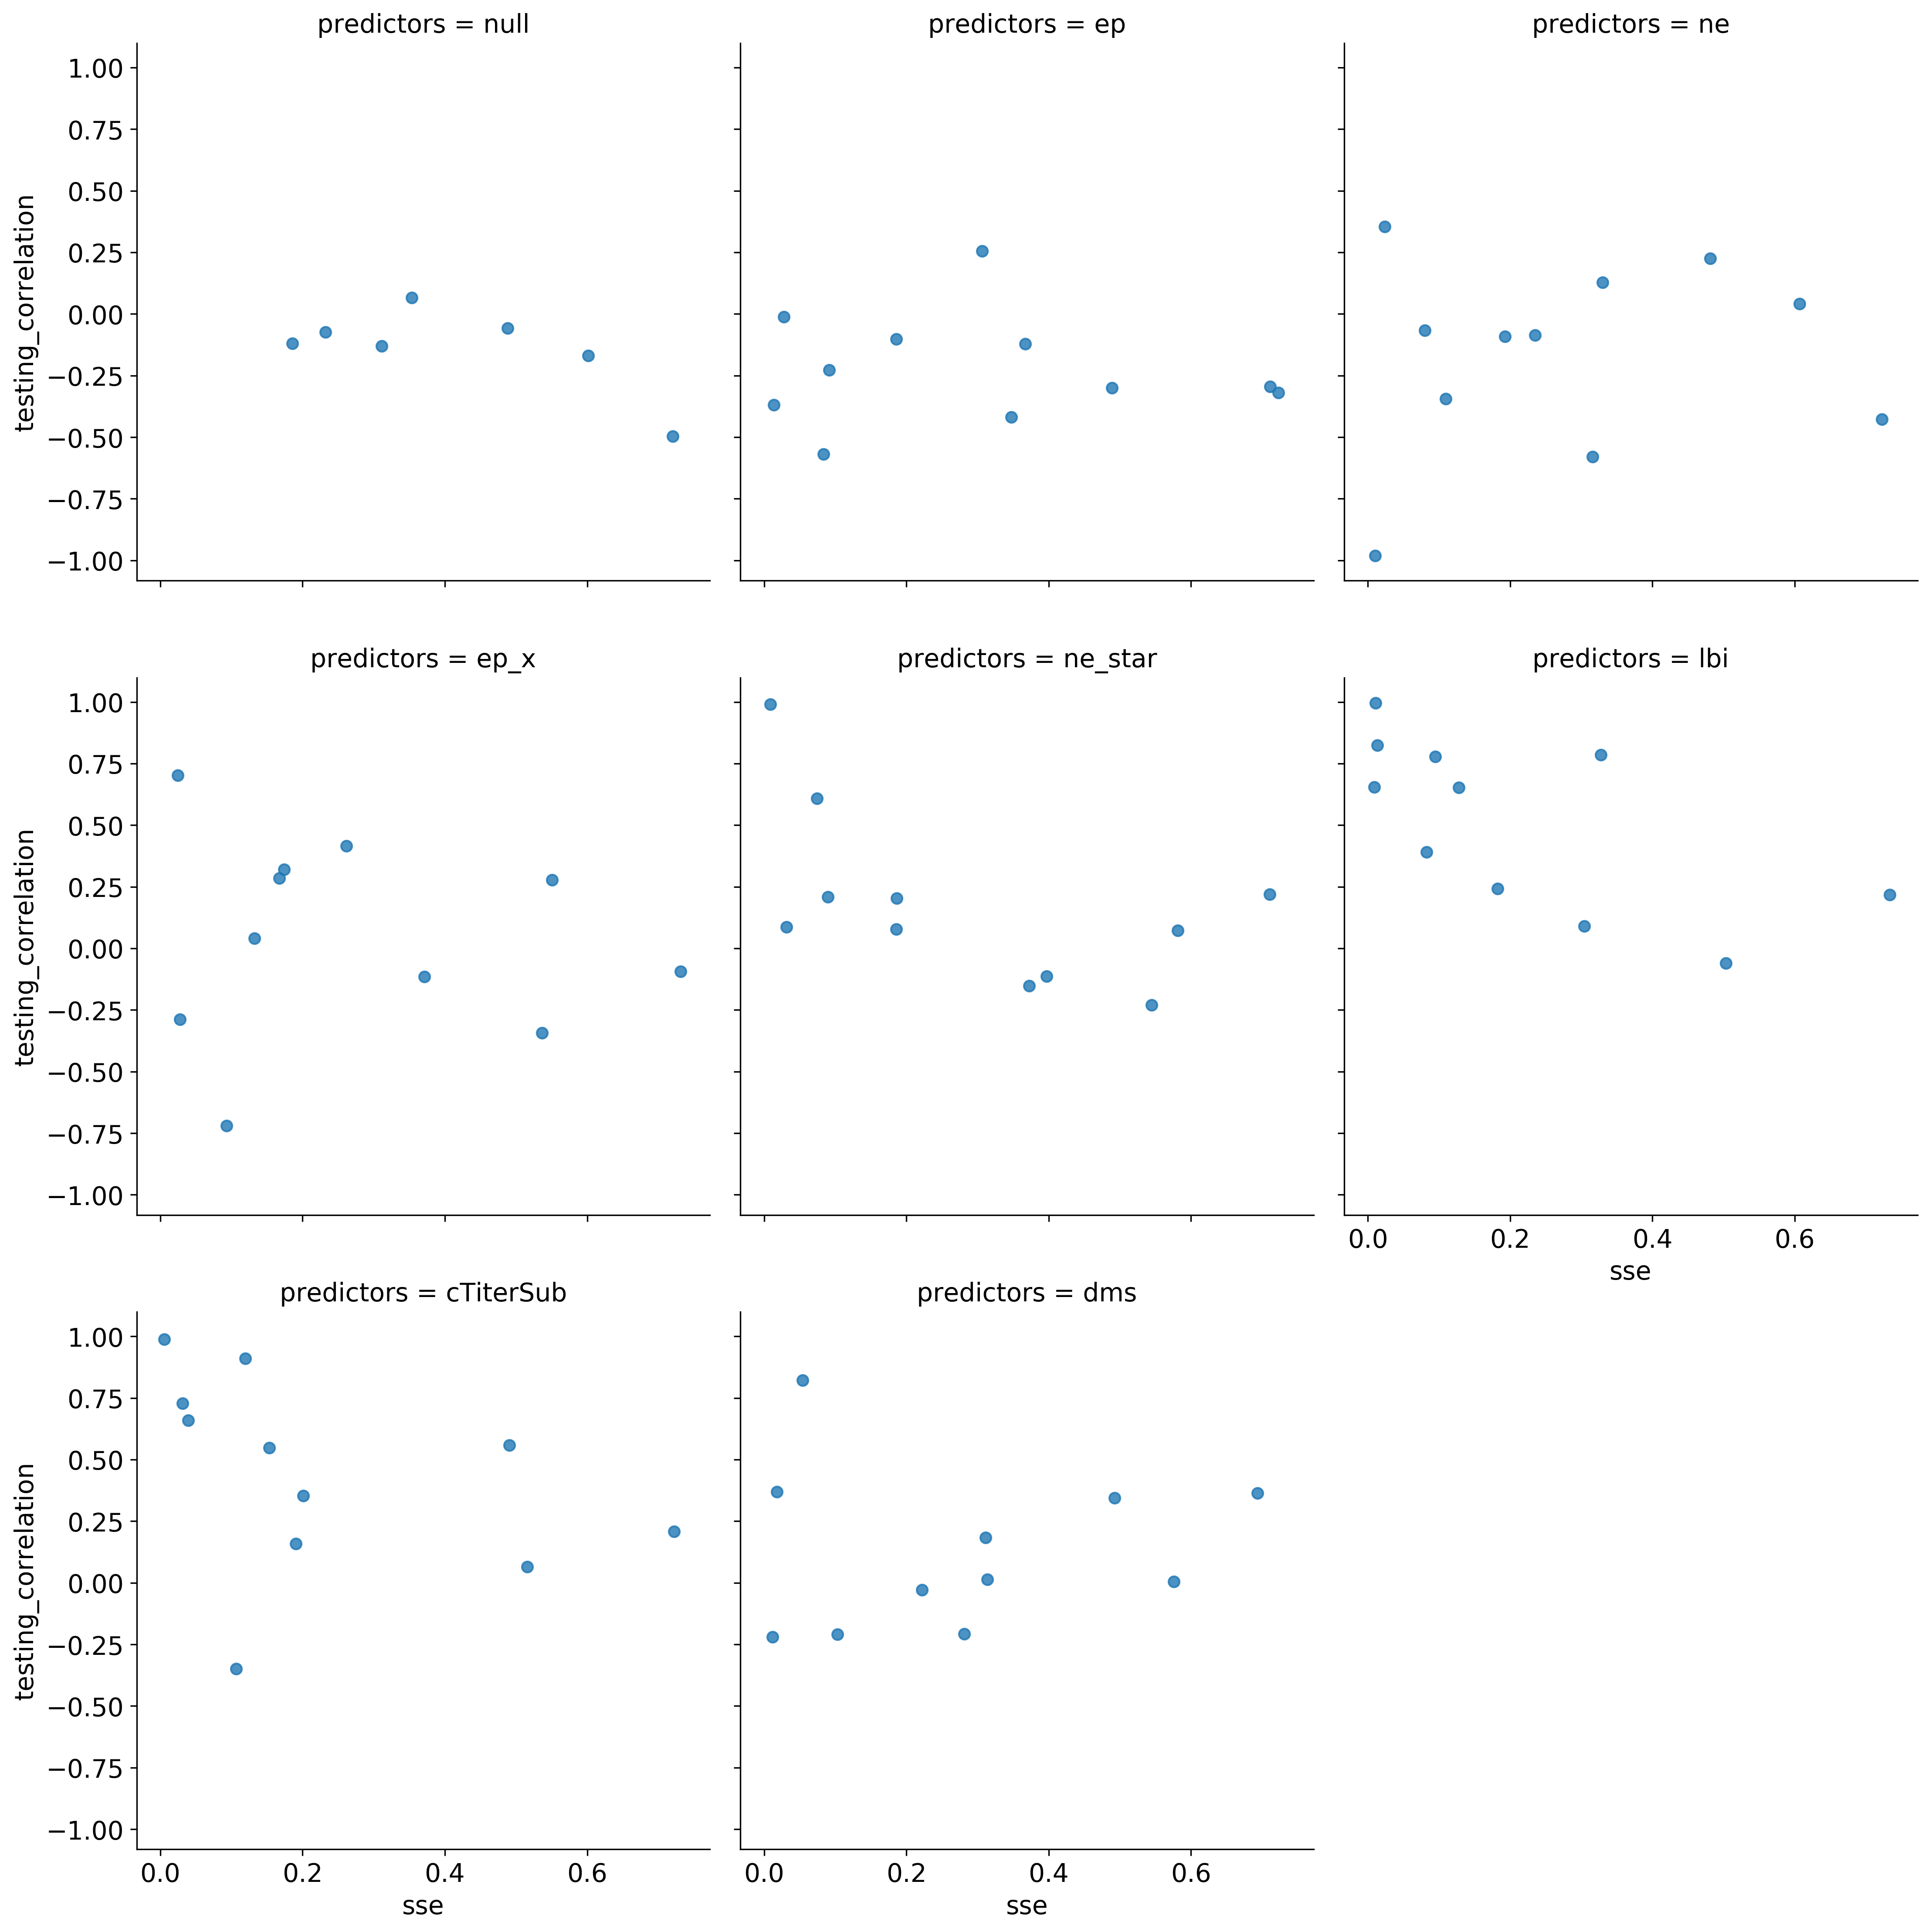

In [22]:
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.lmplot(
    x="sse",
    y="testing_correlation",
    data=df,
    col="predictors",
    col_wrap=3,
    fit_reg=False
)

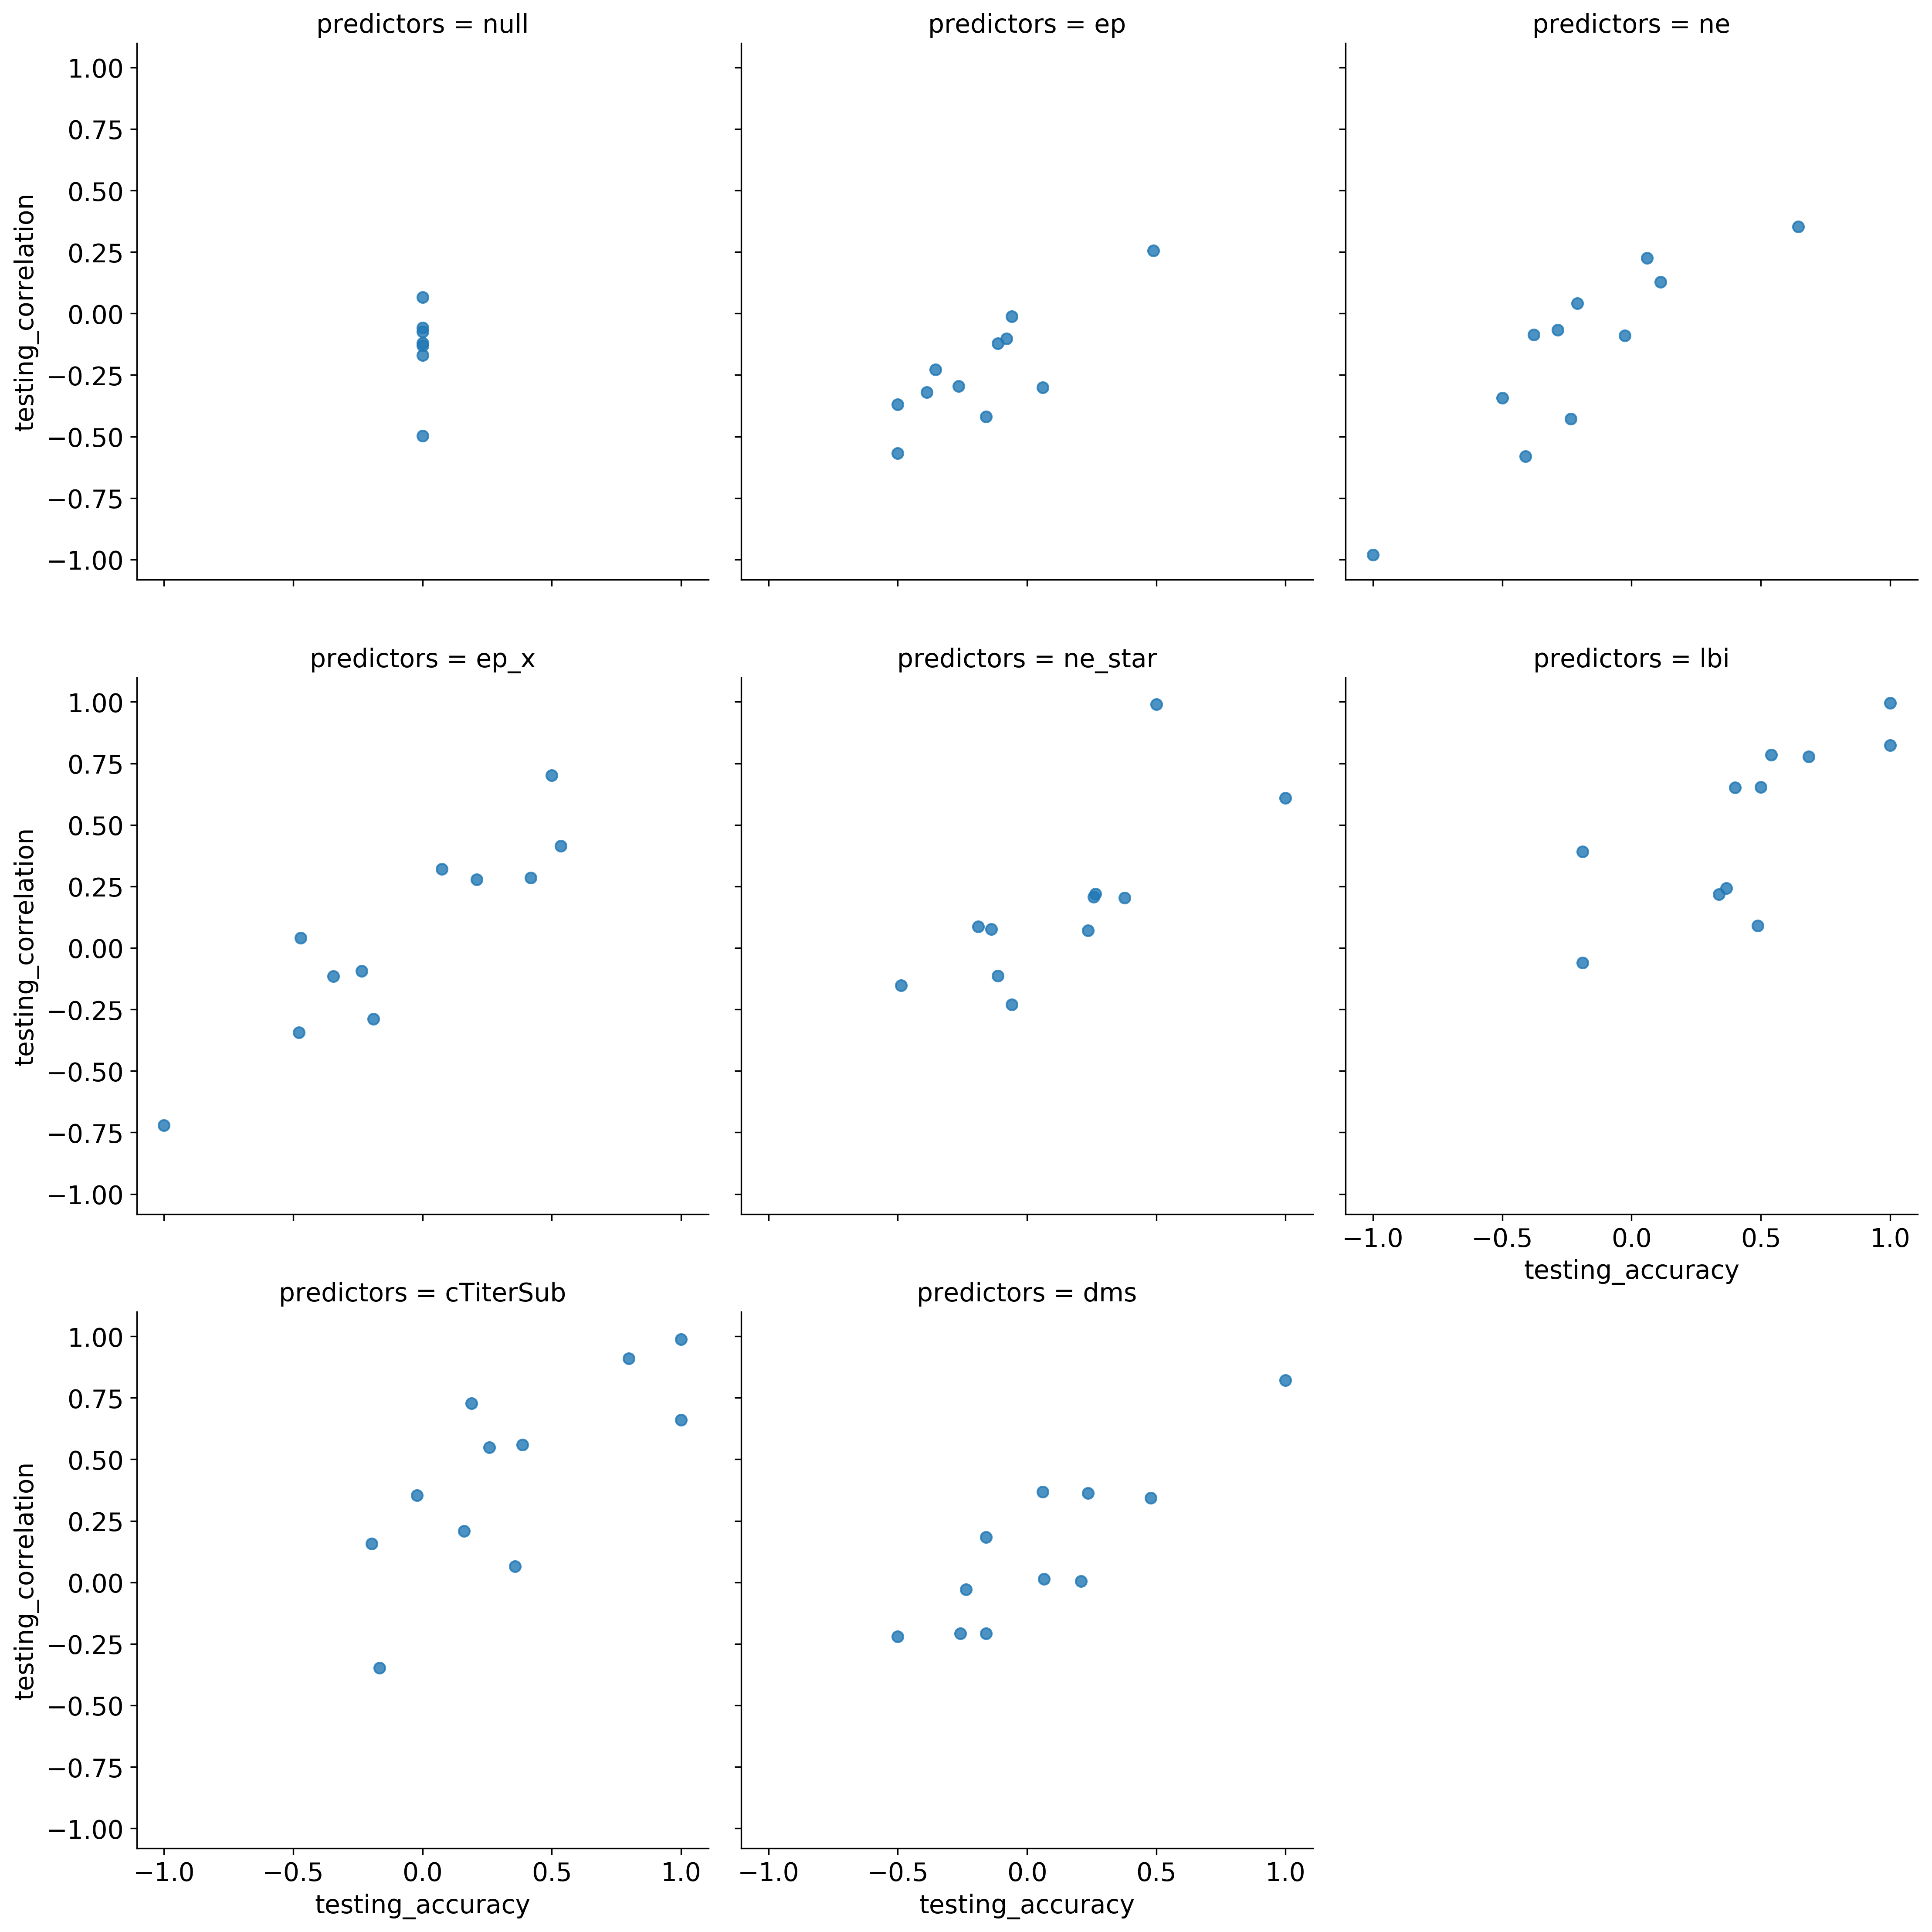

In [23]:
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.lmplot(
    x="testing_accuracy",
    y="testing_correlation",
    data=df,
    col="predictors",
    col_wrap=3,
    fit_reg=False
)

In [24]:
df.head()

fn  fp  last_training_timepoint  n_samples  parameter-cTiterSub  \
0   0   2                  2011.25          3                  NaN   
1   0  16                  2011.75         17                  NaN   
2   0  10                  2012.25         12                  NaN   
3   0   1                  2012.75          3                  NaN   
4   0  21                  2013.25         24                  NaN   

   parameter-dms  parameter-ep  parameter-ep_x  parameter-lbi  parameter-ne  \
0            NaN           NaN             NaN            NaN           NaN   
1            NaN           NaN             NaN            NaN           NaN   
2            NaN           NaN             NaN            NaN           NaN   
3            NaN           NaN             NaN            NaN           NaN   
4            NaN           NaN             NaN            NaN           NaN   

      ...      test_timepoint  testing_accuracy testing_correlation  tn  tp  \
0     ...             2012.25               0.0                 NaN   0   1   
1     ...             2012.75               0.0           -0.169651   0   1   
2     ...             2013.25               0.0           -0.073367   0   2   
3     ...             2013.75               0.0                 NaN   0   2   
4     ...             2014.25               0.0           -0.129709   0   3   

   training_accuracy  training_correlation  training_windows  viruses  \
0          -0.019562              0.032837                 9       92   
1          -0.089838              0.044232                10       92   
2          -0.081786              0.042378                11       92   
3          -0.088273              0.016135                12       92   
4          -0.080249              0.000197                13       92   

   year_range  
0   2006-2018  
1   2006-2018  
2   2006-2018  
3   2006-2018  
4   2006-2018  

[5 rows x 26 columns]

In [25]:
df["predictors"].unique()

array(['null', 'ep', 'ne', 'ep_x', 'ne_star', 'lbi', 'cTiterSub', 'dms'], dtype=object)

In [26]:
parameter_columns = [column for column in df.columns if column.startswith("parameter-")]
df.loc[:, ["predictors"] + parameter_columns].groupby("predictors").aggregate(["mean", "std"])

parameter-cTiterSub           parameter-dms           parameter-ep  \
                          mean       std          mean       std         mean   
predictors                                                                      
cTiterSub             0.641288  0.295741           NaN       NaN          NaN   
dms                        NaN       NaN      0.361686  0.017924          NaN   
ep                         NaN       NaN           NaN       NaN    -0.054417   
ep_x                       NaN       NaN           NaN       NaN          NaN   
lbi                        NaN       NaN           NaN       NaN          NaN   
ne                         NaN       NaN           NaN       NaN          NaN   
ne_star                    NaN       NaN           NaN       NaN          NaN   
null                       NaN       NaN           NaN       NaN          NaN   

                     parameter-ep_x           parameter-lbi            \
                 std           mean       std          mean       std   
predictors                                                              
cTiterSub        NaN            NaN       NaN           NaN       NaN   
dms              NaN            NaN       NaN           NaN       NaN   
ep          0.147162            NaN       NaN           NaN       NaN   
ep_x             NaN       0.969273  0.640875           NaN       NaN   
lbi              NaN            NaN       NaN      0.552568  0.115079   
ne               NaN            NaN       NaN           NaN       NaN   
ne_star          NaN            NaN       NaN           NaN       NaN   
null             NaN            NaN       NaN           NaN       NaN   

           parameter-ne           parameter-ne_star           parameter-null  \
                   mean       std              mean       std           mean   
predictors                                                                     
cTiterSub           NaN       NaN               NaN       NaN            NaN   
dms                 NaN       NaN               NaN       NaN            NaN   
ep                  NaN       NaN               NaN       NaN            NaN   
ep_x                NaN       NaN               NaN       NaN            NaN   
lbi                 NaN       NaN               NaN       NaN            NaN   
ne             0.108222  0.295657               NaN       NaN            NaN   
ne_star             NaN       NaN         -1.860788  0.618524            NaN   
null                NaN       NaN               NaN       NaN            0.0   

                 
            std  
predictors       
cTiterSub   NaN  
dms         NaN  
ep          NaN  
ep_x        NaN  
lbi         NaN  
ne          NaN  
ne_star     NaN  
null        0.0

In [181]:
parameters_df = df.loc[:, ["predictor_name"] + parameter_columns].melt(
    "predictor_name",
    parameter_columns,
    var_name="predictor",
    value_name="parameter"
).dropna().copy()

In [183]:
parameters_df["predictor"] = parameters_df["predictor_name"].str.replace("parameter-", "")

In [184]:
parameters_df.head()

predictor_name      predictor  parameter
44  HI phenotypes  HI phenotypes   0.180367
45  HI phenotypes  HI phenotypes   0.220429
46  HI phenotypes  HI phenotypes   0.266588
47  HI phenotypes  HI phenotypes   0.533250
48  HI phenotypes  HI phenotypes   0.711134

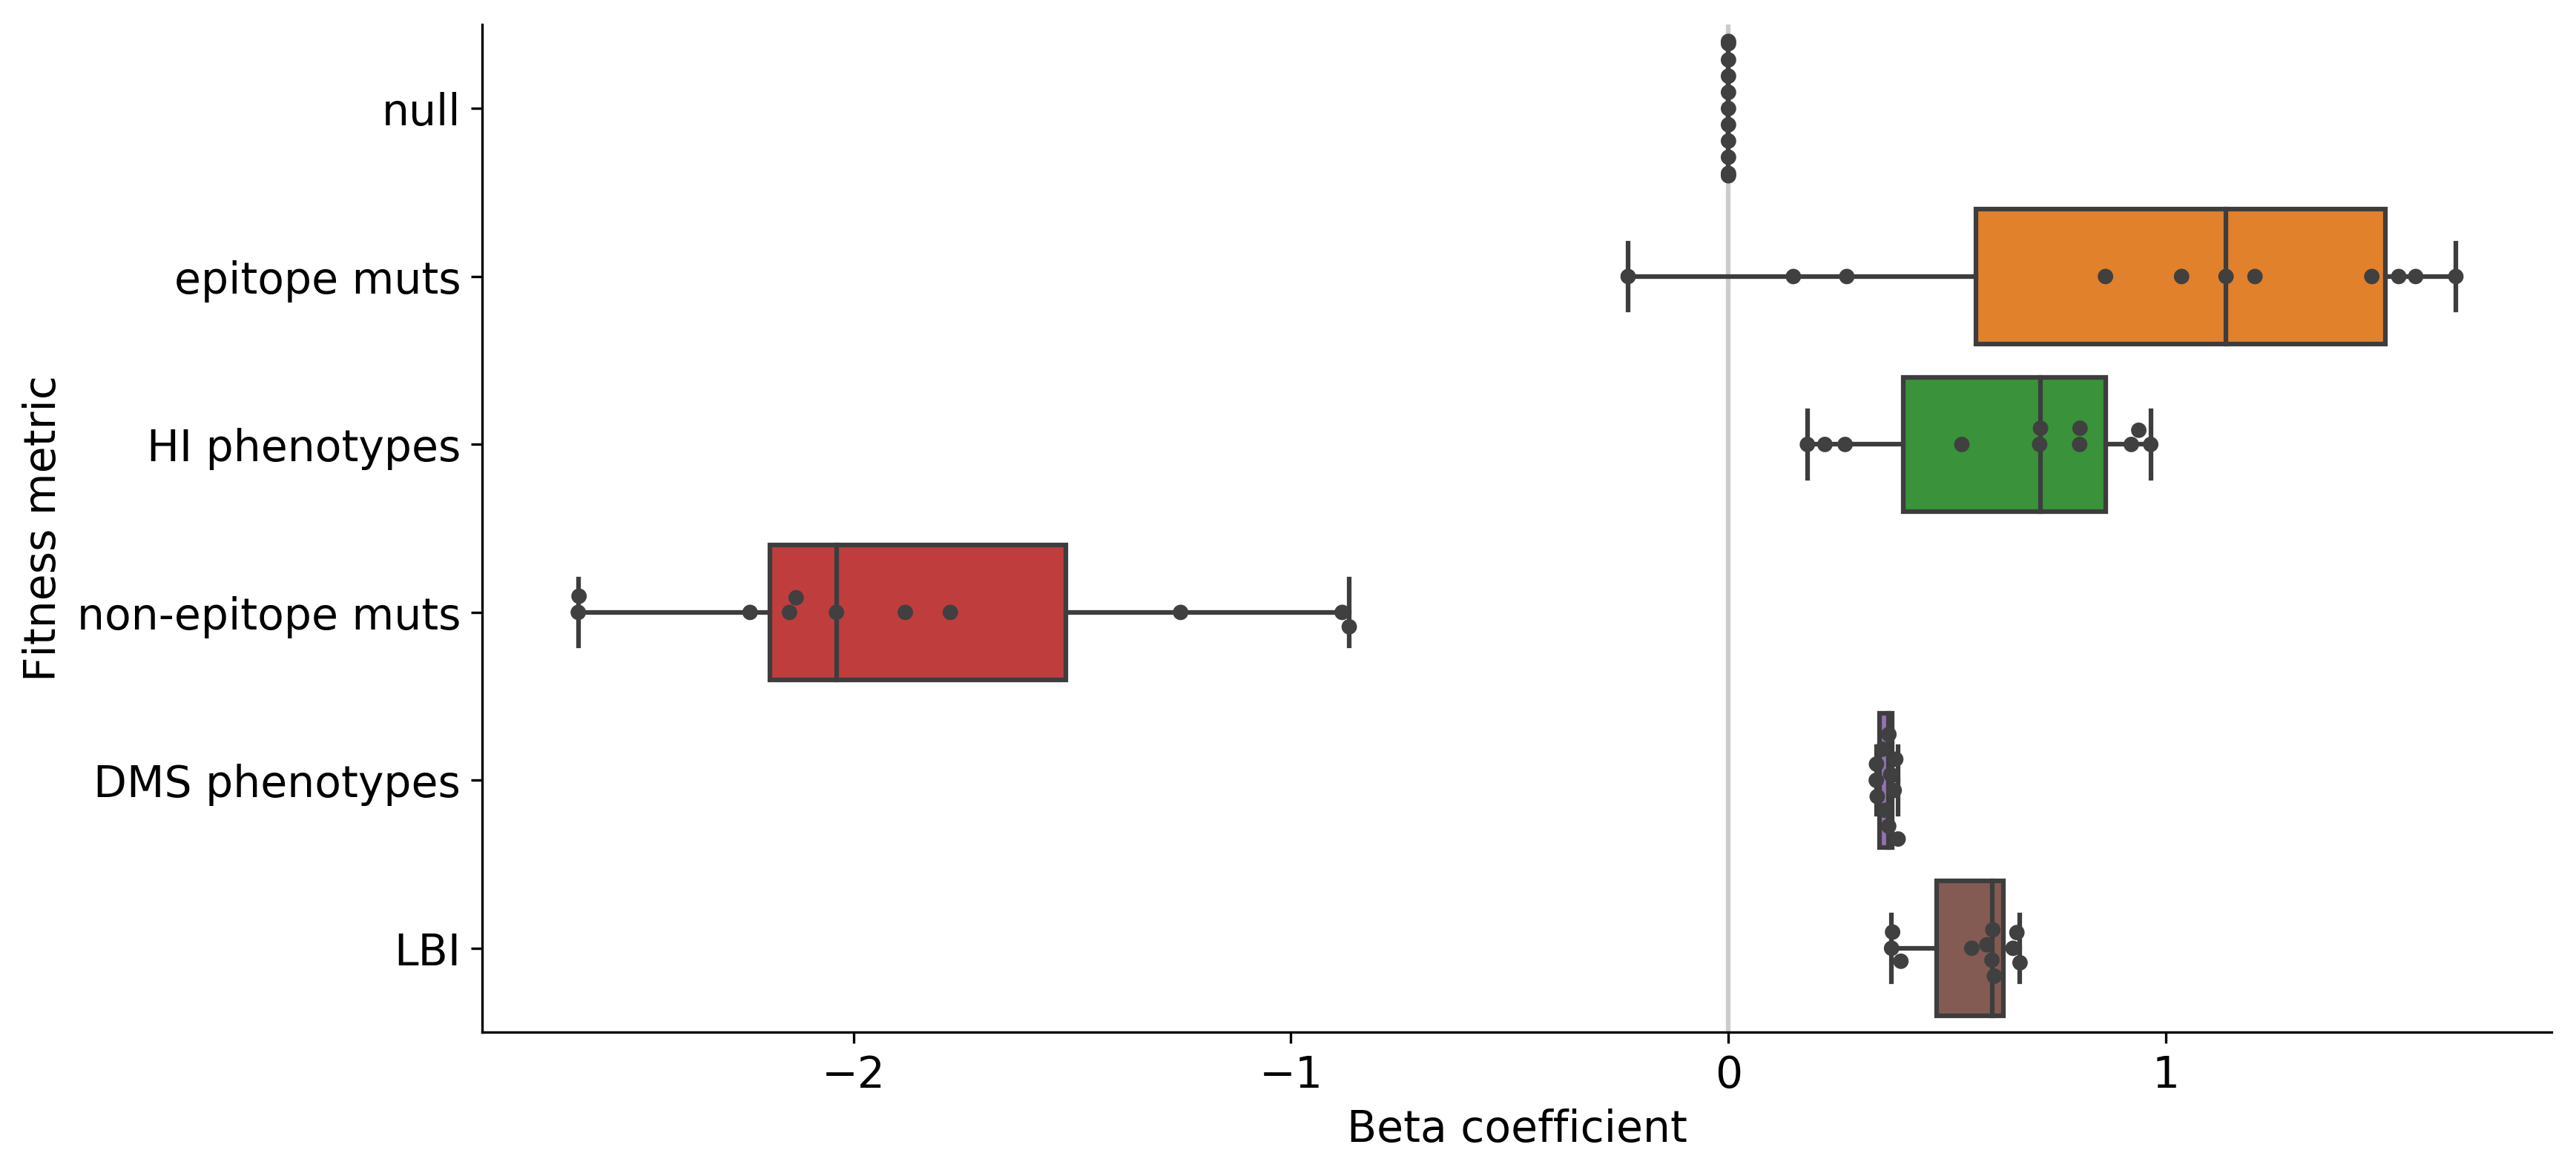

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(
    y="predictor_name",
    x="parameter",
    data=parameters_df,
    ax=ax,
    dodge=False,
    order=predictor_names_order
)

sns.swarmplot(
    y="predictor_name",
    x="parameter",
    data=parameters_df,
    ax=ax,
    color="0.25",
    order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [31]:
df[df["predictors"] == "cTiterSub"].loc[:, ["fn", "fp", "tn", "tp"]].sum()

fn     8
fp    32
tn    82
tp    11
dtype: int64

In [32]:
df[df["predictors"] == "cTiterSub"].loc[:, ["fn", "fp", "tn", "tp"]].sum().sum()

133

In [33]:
df[df["predictors"] == "cTiterSub"].loc[:, ["fn", "fp", "tn", "tp"]].sum(axis=1)

66     3
67    17
68    12
69     3
70    24
71    17
72    17
73     9
74     7
75     9
76    15
dtype: int64

## Load raw model data

These data include observed and predicted clade frequencies for all clades across all timepoints in the cross-validation test data.

In [187]:
model_df = pd.read_table("models.tab", keep_default_na=False, na_values="N/A")

In [188]:
model_df.head()

clade  clade_size  initial_freq  observed_freq  predicted_freq  \
0  NODE_0000810         819      0.218169       0.054913        0.218174   
1  NODE_0011971          17      0.011282       0.001450        0.011282   
2  NODE_0003569        6609      0.694538       0.917818        0.694555   
3  NODE_0000811          18      0.021869       0.000144        0.021870   
4  NODE_0000809         801      0.154742       0.007328        0.154746   

   projected_timepoint  timepoint year_range  viruses predictors  sample  
0              2013.25    2012.25  2006-2018       92       null       0  
1              2013.25    2012.25  2006-2018       92       null       0  
2              2013.25    2012.25  2006-2018       92       null       0  
3              2013.75    2012.75  2006-2018       92       null       0  
4              2013.75    2012.75  2006-2018       92       null       0

In [189]:
model_df["observed_growth_rate"] = model_df["observed_freq"] / model_df["initial_freq"]
model_df["predicted_growth_rate"] = model_df["predicted_freq"] / model_df["initial_freq"]

In [190]:
test_df = model_df[model_df["predictors"] == "lbi"].copy()

In [191]:
correlation = pearsonr(test_df["observed_growth_rate"], test_df["predicted_growth_rate"])[0]
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(test_df, return_confusion_matrix=True)
accuracy = (confusion_matrix["tp"] + confusion_matrix["tn"]) / float(sum(confusion_matrix.values()))

(0, 5)

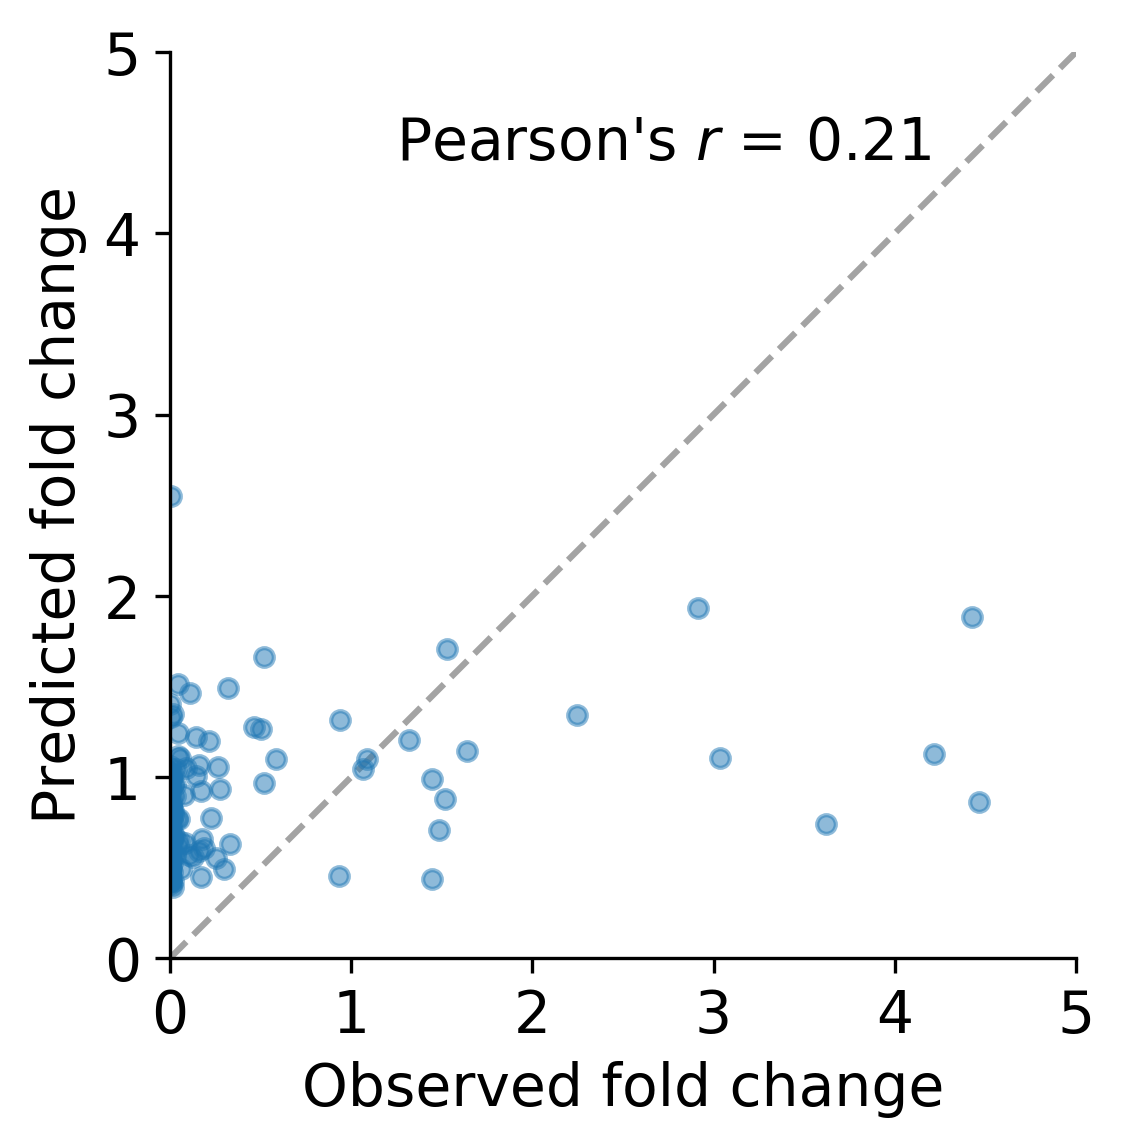

In [192]:
min_rate = 0
max_rate = 5
x = y = np.linspace(min_rate, max_rate, 100)
ax = test_df.plot(
    x="observed_growth_rate",
    y="predicted_growth_rate",
    kind="scatter",
    alpha=0.5,
    figsize=(4, 4)
)
ax.plot(x, y, "--", color="#999999", alpha=0.9, zorder=-10)
ax.text(
    0.25,
    0.9,
    "Pearson's $r$ = %.2f" % correlation,
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
)

ax.set_xlabel("Observed fold change")
ax.set_ylabel("Predicted fold change")
ax.set_aspect("equal")
ax.set_xlim(min_rate, max_rate)
ax.set_ylim(min_rate, max_rate)

In [193]:
accurate_clades = (
    ((test_df["observed_growth_rate"] > 1) & (test_df["predicted_growth_rate"] > 1)) |
    ((test_df["observed_growth_rate"] < 1) & (test_df["predicted_growth_rate"] < 1))
)

(0, 5)

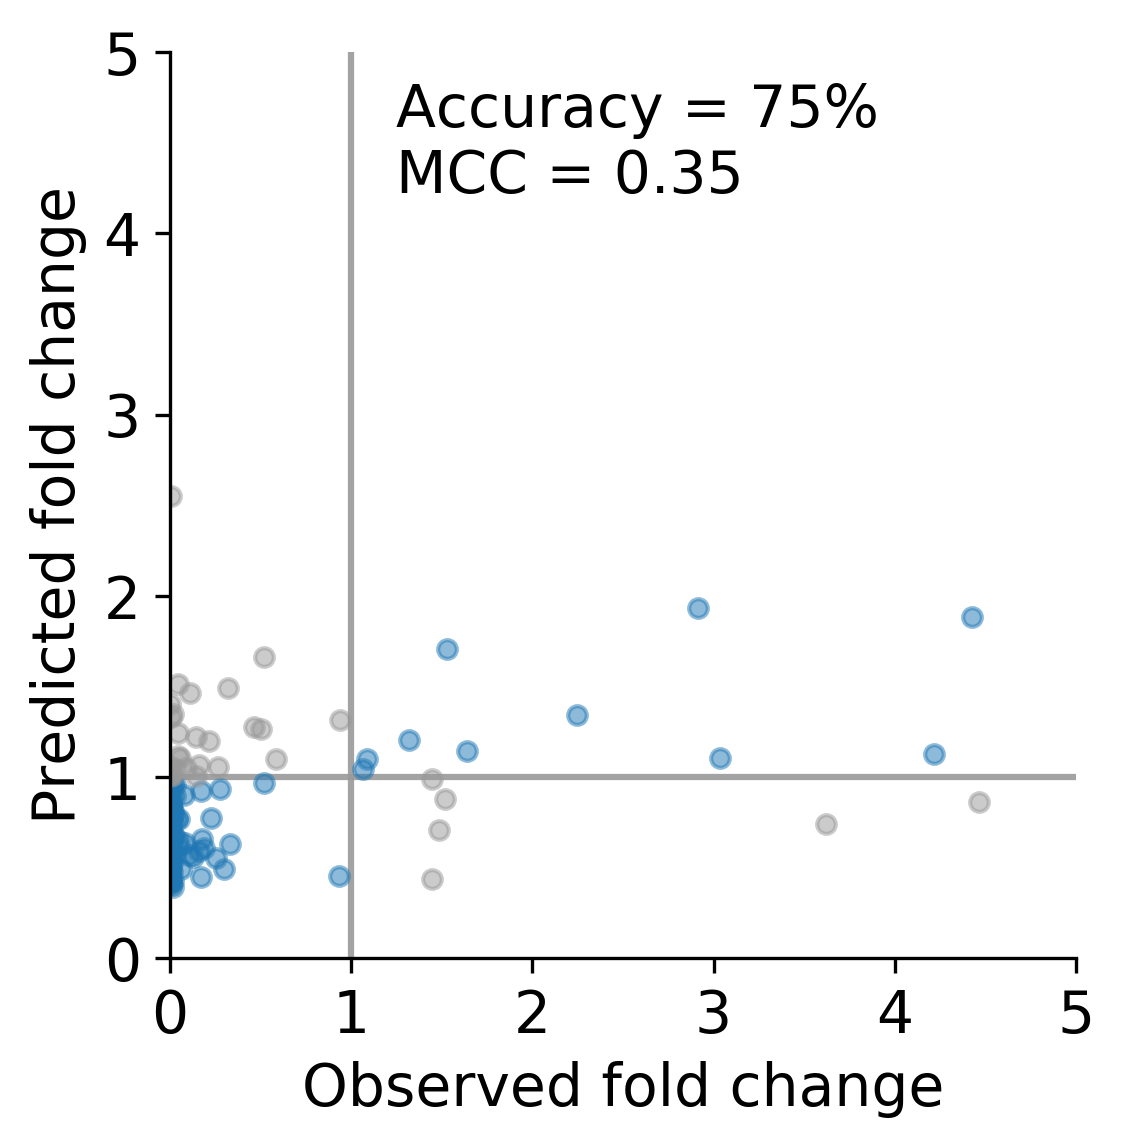

In [194]:
min_rate = 0
max_rate = 5
ax = test_df[accurate_clades].plot(
    x="observed_growth_rate",
    y="predicted_growth_rate",
    kind="scatter",
    alpha=0.5,
    figsize=(4, 4)
)
ax = test_df[~accurate_clades].plot(
    ax=ax,
    x="observed_growth_rate",
    y="predicted_growth_rate",
    kind="scatter",
    alpha=0.5,
    color="#999999"
)

ax.axhline(1, color="#999999", alpha=0.9, zorder=-10)
ax.axvline(1, color="#999999", alpha=0.9, zorder=-10)
ax.text(
    0.25,
    0.9,
    "Accuracy = %i%%\nMCC = %.2f" % (accuracy * 100, mcc),
    transform=ax.transAxes,
    horizontalalignment="left",
    verticalalignment="center"
)

ax.set_xlabel("Observed fold change")
ax.set_ylabel("Predicted fold change")
ax.set_aspect("equal")
ax.set_xlim(min_rate, max_rate)
ax.set_ylim(min_rate, max_rate)

In [195]:
df_by_timepoint = model_df.groupby(["predictors", "timepoint", "sample"])

In [196]:
model_correlation_by_time = df_by_timepoint.apply(
    calculate_correlation_for_df
).reset_index(name="correlation")

In [197]:
test = model_correlation_by_time[model_correlation_by_time["predictors"].isin(["null", "lbi", "cTiterSub"])].dropna()

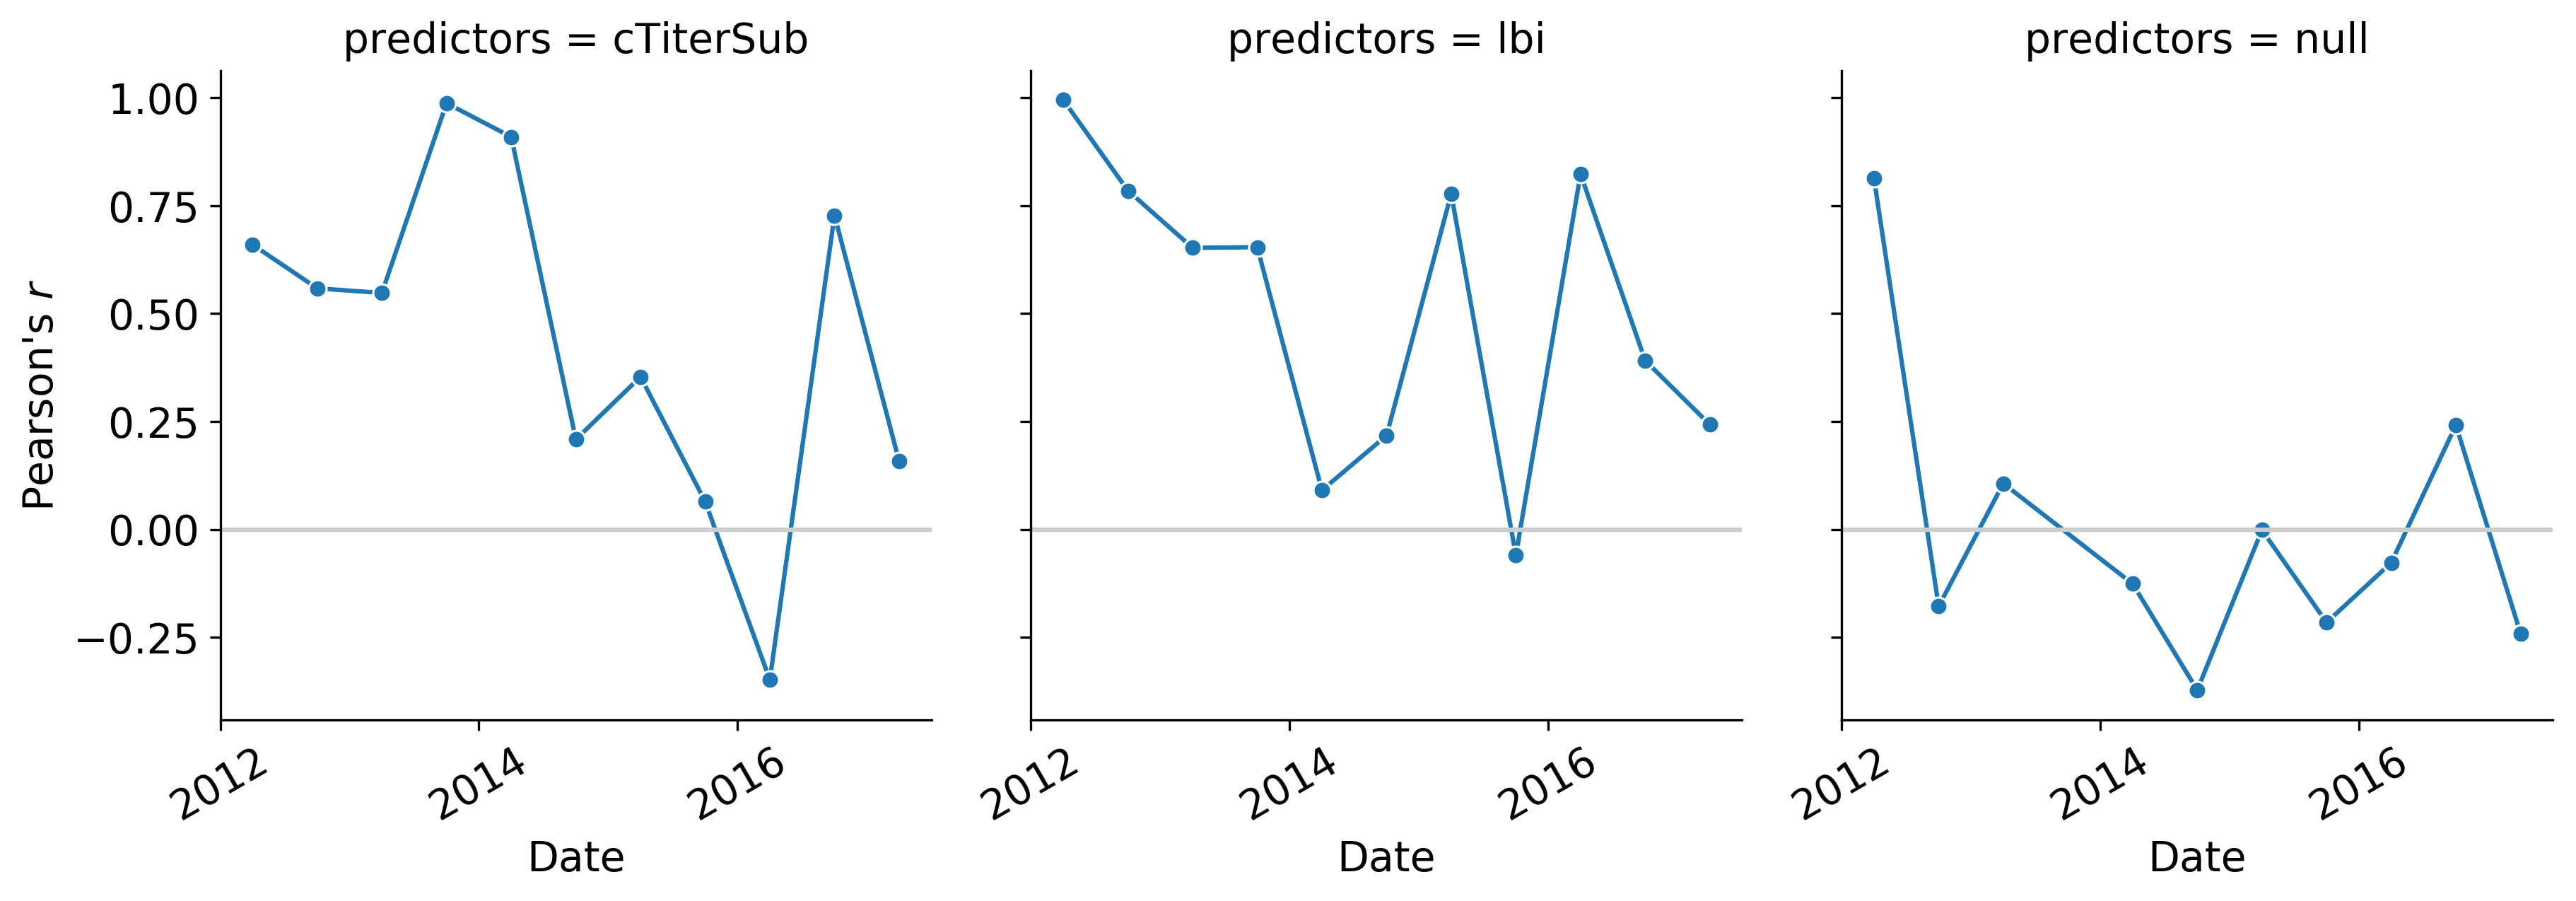

In [198]:
g = facet_time_plot(test, "correlation", "Pearson's $r$")

In [199]:
model_mcc_by_time = df_by_timepoint.apply(
    get_matthews_correlation_coefficient_for_data_frame
).reset_index(name="mcc")

In [200]:
mcc_test = model_mcc_by_time[model_mcc_by_time["predictors"].isin(["null", "lbi", "cTiterSub"])].dropna()

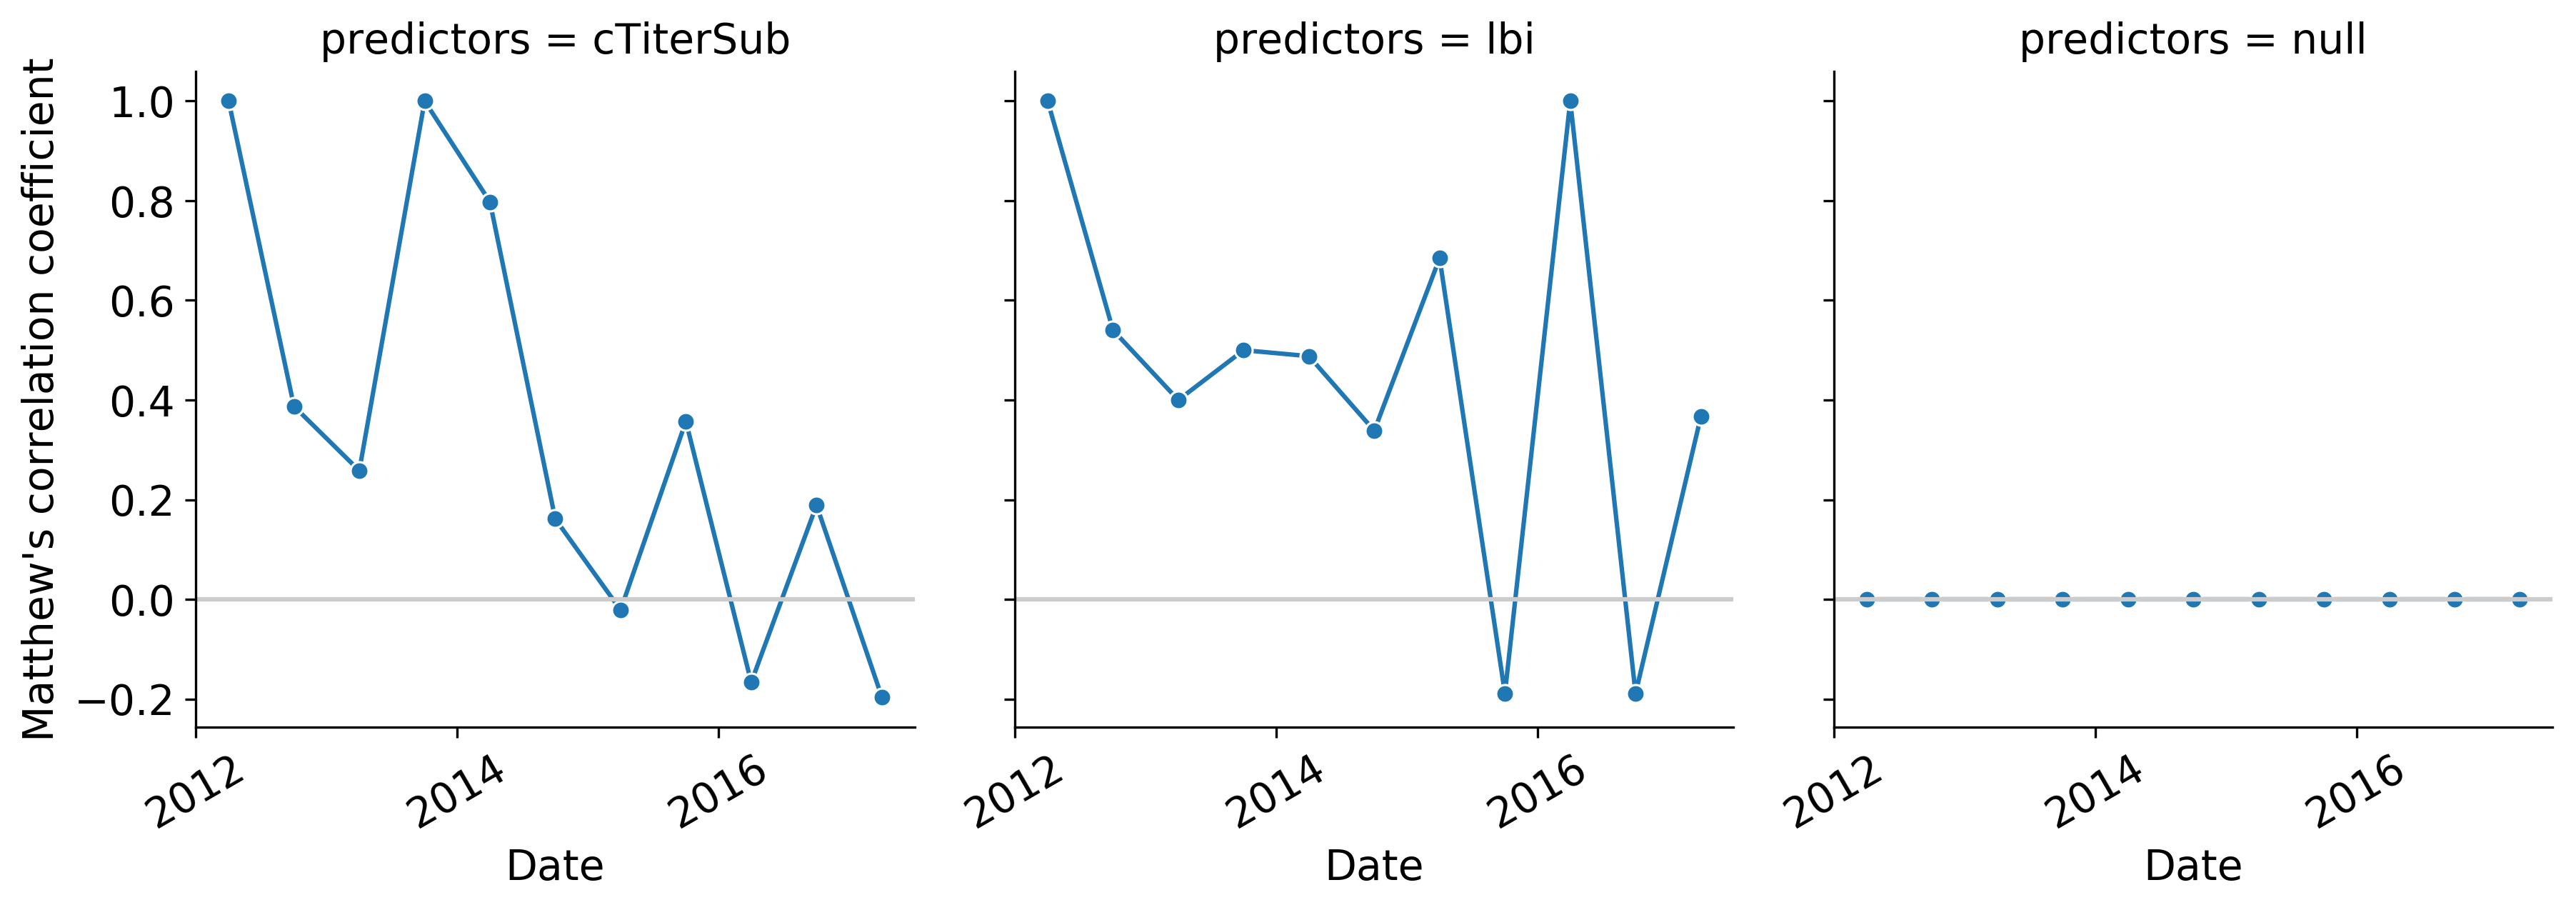

In [201]:
g = facet_time_plot(mcc_test, "mcc", "Matthew's correlation coefficient")

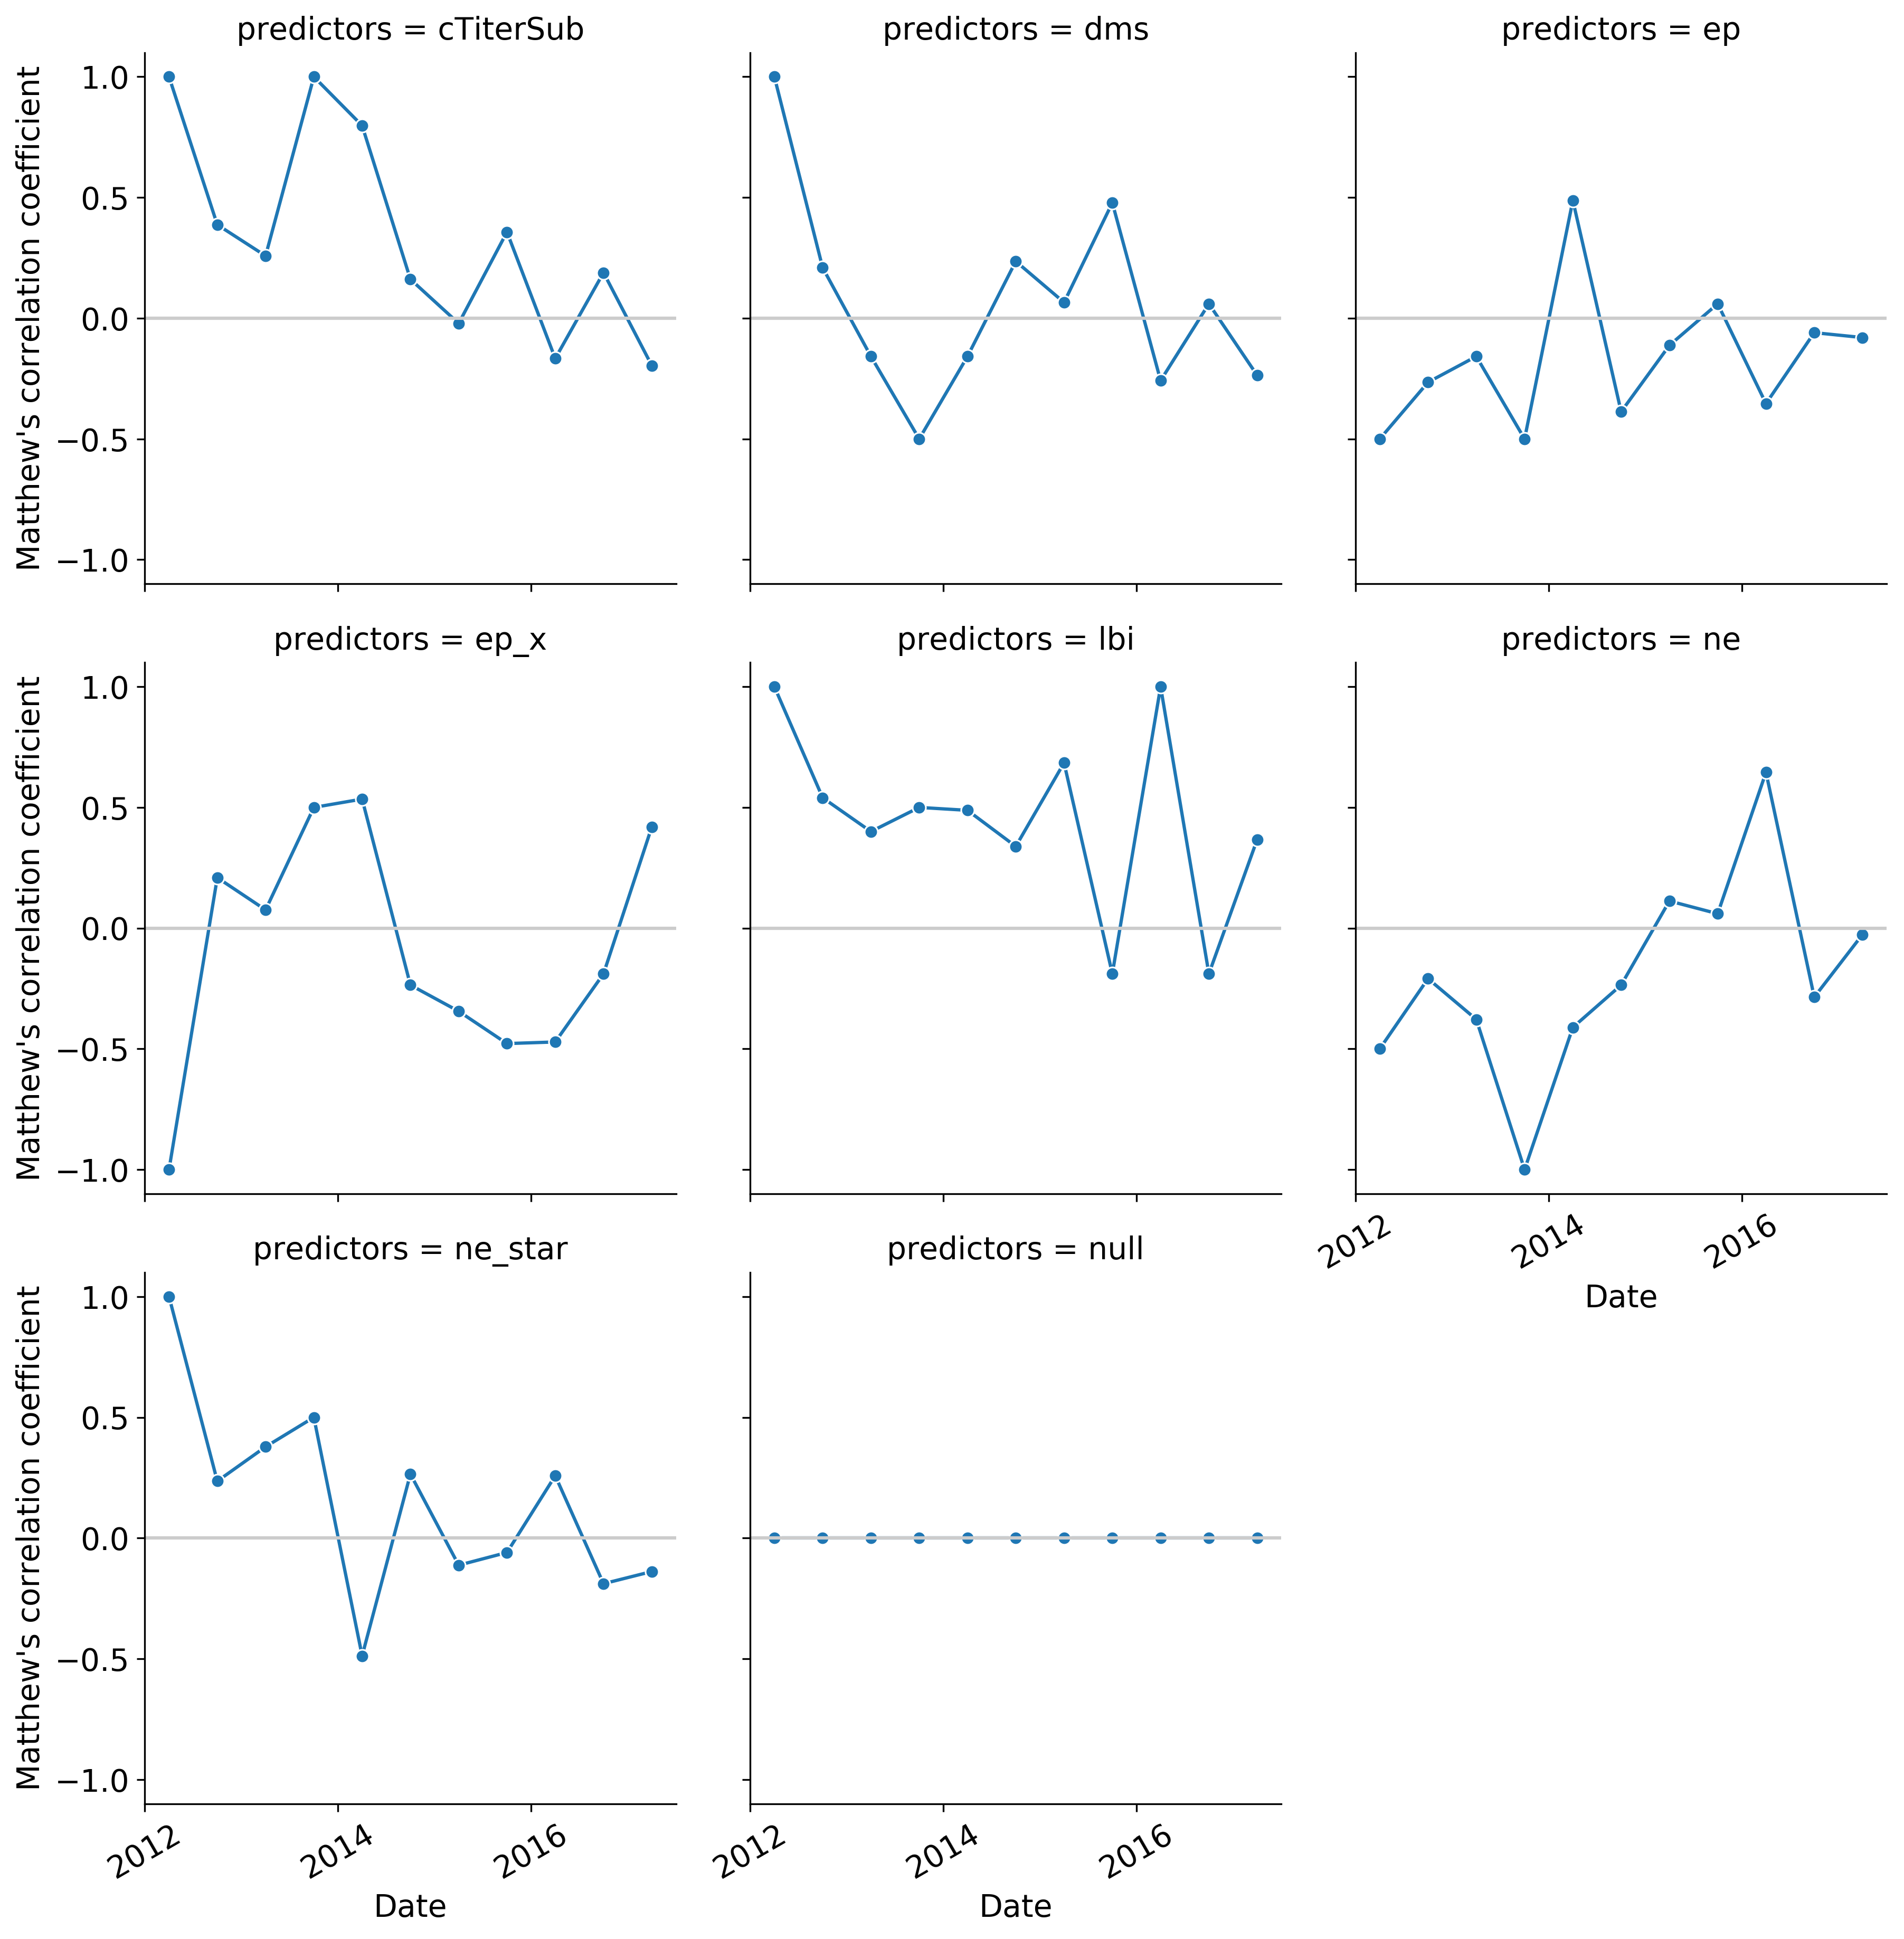

In [202]:
g = facet_time_plot(model_mcc_by_time, "mcc", "Matthew's correlation coefficient")

In [203]:
model_mse_by_time = df_by_timepoint.apply(
    mse_for_df
).reset_index(name="mse")

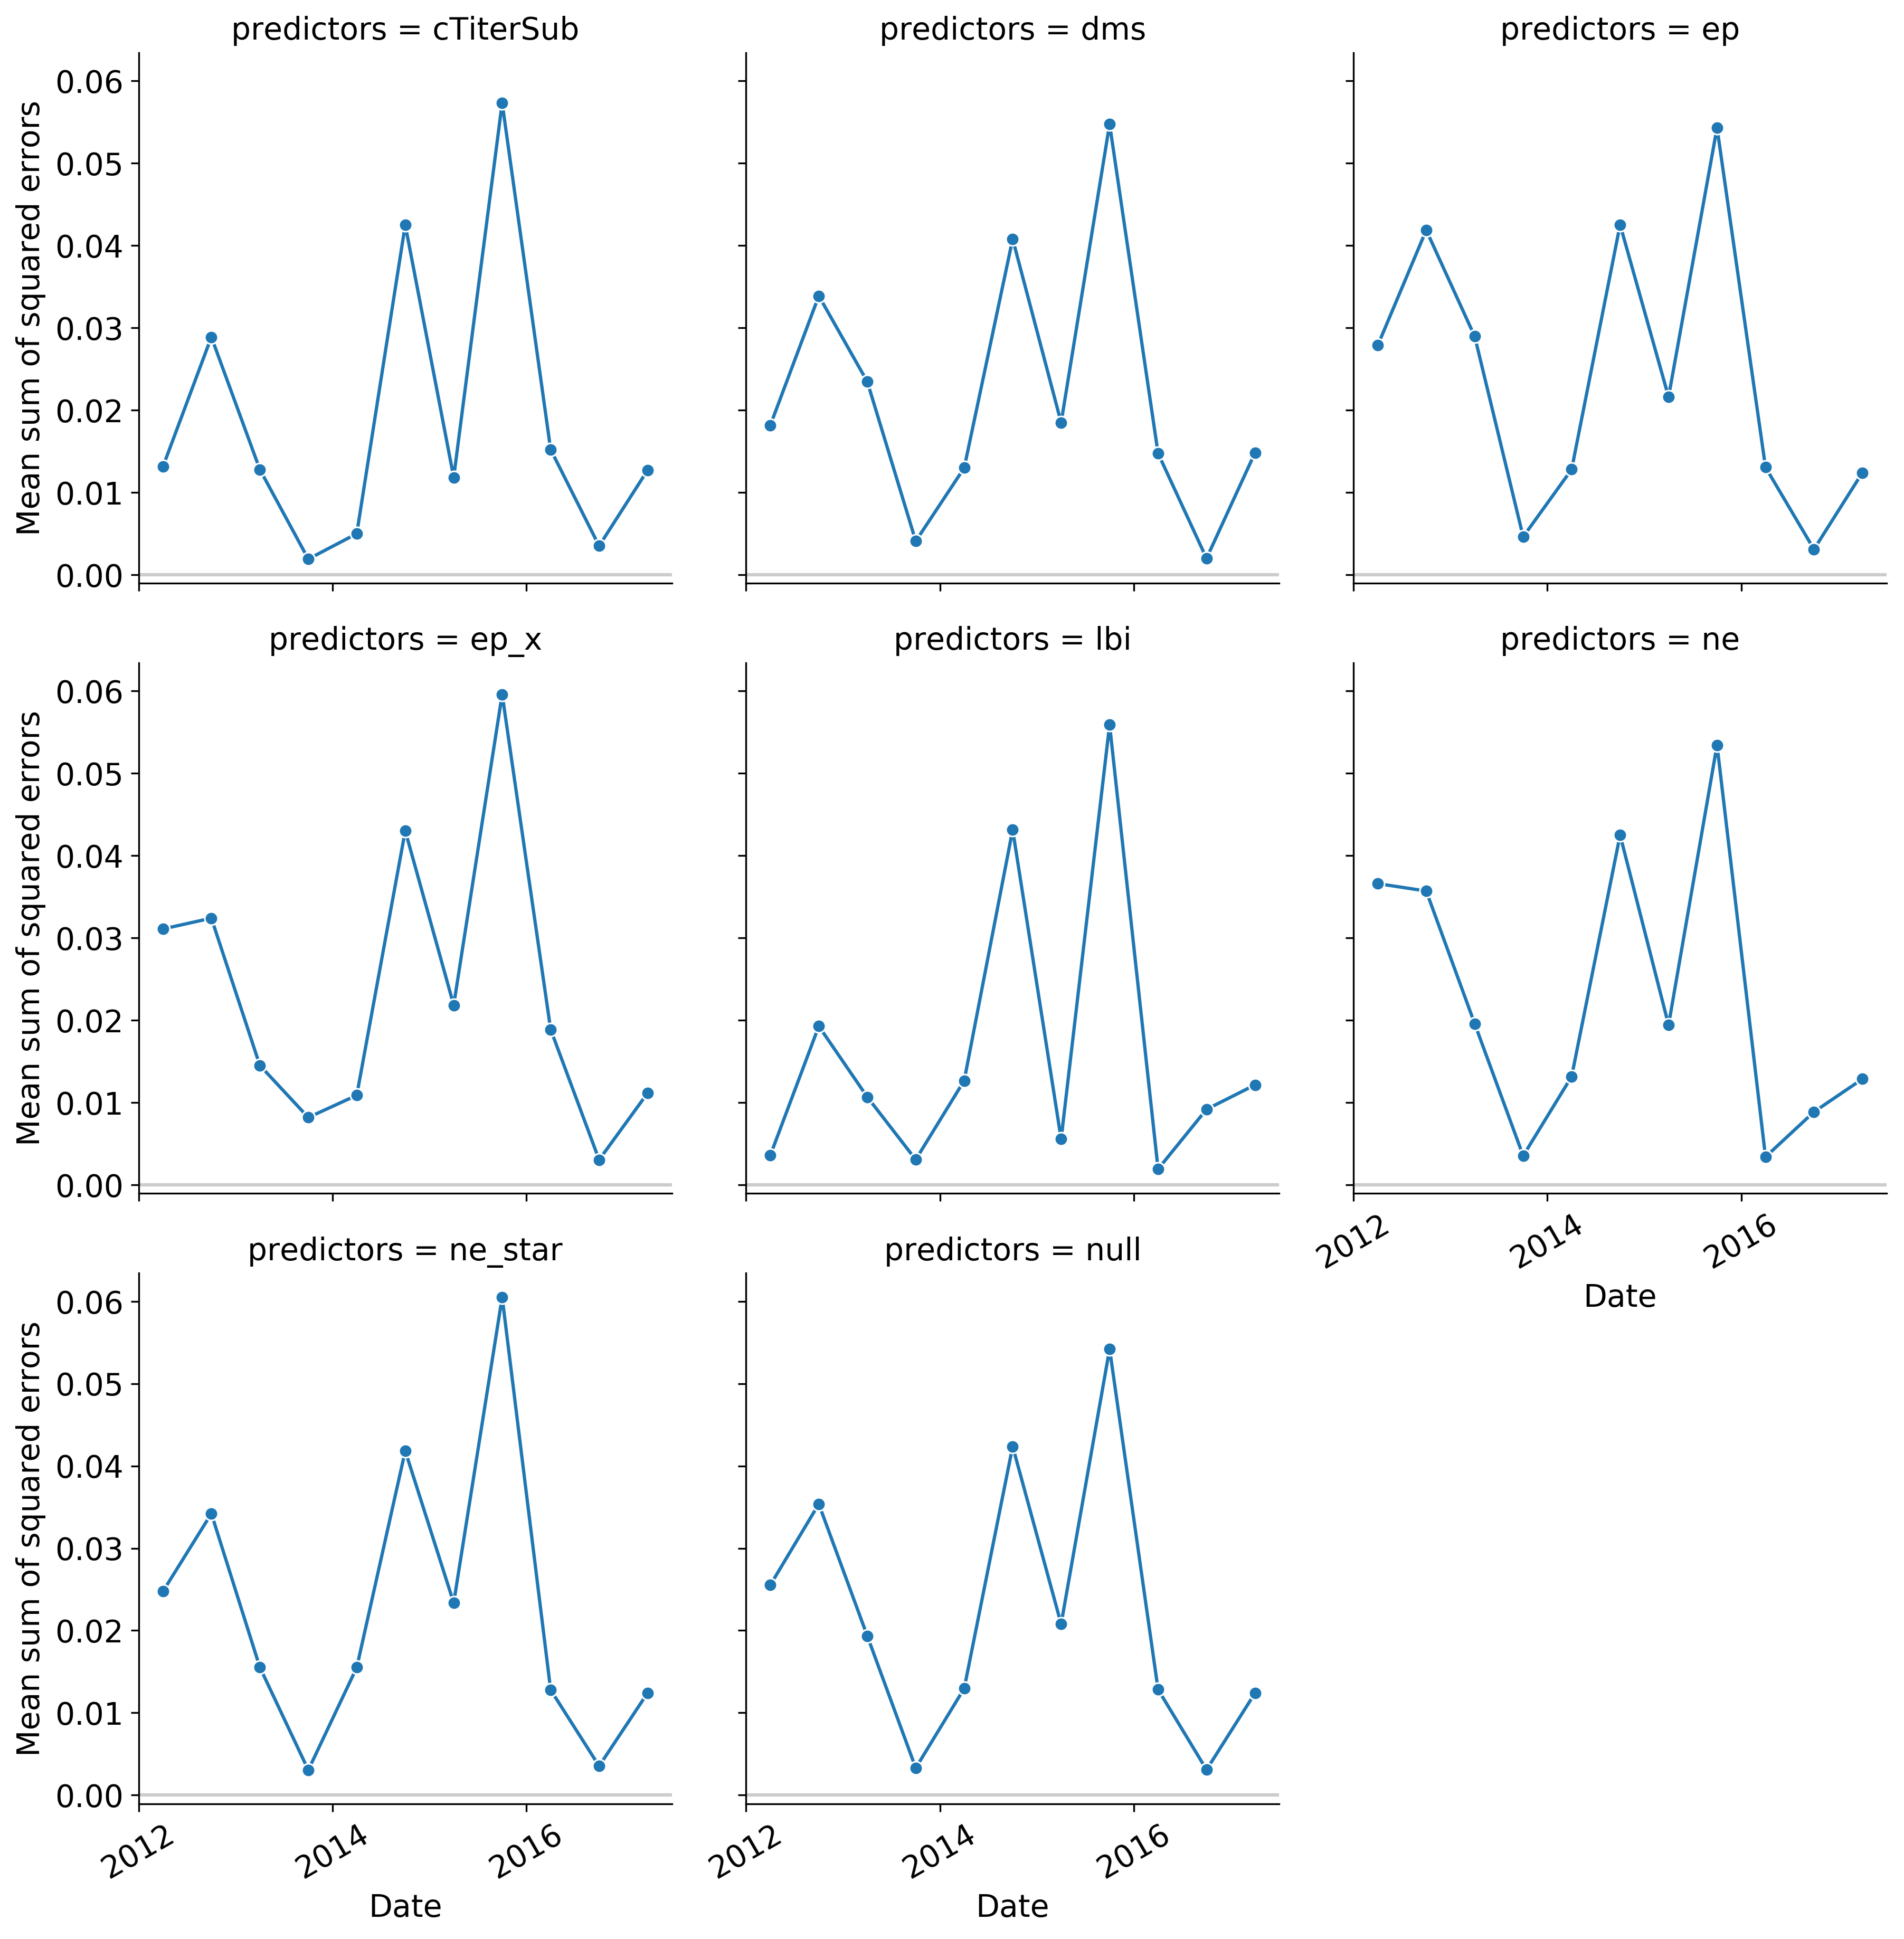

In [204]:
g = facet_time_plot(model_mse_by_time, "mse", "Mean sum of squared errors")